# 🚀 Production-Grade CNN with CLASS BALANCING
## Target: 95%+ Accuracy with Balanced Performance Across ALL Classes

**🎯 CLASS IMBALANCE FIXES (NEW):**
- ✅ **Class-Weighted Focal Loss** - Minority classes get 3-5x higher penalty
- ✅ **Weighted Random Sampler** - Balances training distribution automatically  
- ✅ **Enhanced Focal Loss (γ=3.0)** - Focuses on hard misclassified examples
- ✅ **Macro F1 Score Tracking** - Primary metric (better than accuracy for imbalance)
- ✅ **Per-Class Performance Monitoring** - Track Eczema, Warts, etc. individually
- ✅ **Strong Augmentation for Minorities** - Extra variations for rare classes

**✨ ALL ORIGINAL FEATURES PRESERVED:**
- ✅ Multiple backbones (ConvNeXt, EfficientNet, Swin Transformer)
- ✅ 5-Fold Stratified Cross-Validation
- ✅ Advanced augmentation pipeline with AutoAugment
- ✅ Focal Loss + Label Smoothing
- ✅ EMA (Exponential Moving Average) weights
- ✅ Mixed Precision Training (AMP)
- ✅ Mixup & CutMix augmentation
- ✅ Test-Time Augmentation (TTA)
- ✅ Gradient clipping for stability
- ✅ Learning rate warmup
- ✅ Comprehensive metrics & visualization
- ✅ Production-ready inference

**🎓 Perfect for imbalanced medical image datasets!**


## 📦 1. Environment Setup & Dependencies

In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasets/ismailpromus/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/t-factitial-dermatitis-1.jpg
/kaggle/input/datasets/ismailpromus/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/v-eczema-areola-13.jpg
/kaggle/input/datasets/ismailpromus/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/t-eczema-subacute-66.jpg
/kaggle/input/datasets/ismailpromus/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/t-eczema-hand-86.jpg
/kaggle/input/datasets/ismailpromus/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/t-keratolysis-exfoliativa-17.jpg
/kaggle/input/datasets/ismailpromus/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/t-lichen-simplex-chronicus-136.jpg
/kaggle/input/datasets/ismailpromus/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/t-eczema-subacute-60.jpg
/kaggle/input/datasets/ismailpromus/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/t-fissure-11.jpg
/kaggle/input/datasets/ismailpromus/skin-diseases-image-dataset/

In [26]:
# Auto-install dependencies
import sys
import subprocess

def pip_install(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

packages = ["timm", "albumentations", "opencv-python", "seaborn", "scikit-learn", "tqdm"]

for p in packages:
    try:
        __import__(p.replace('-', '_').split('[')[0])
    except ImportError:
        print(f"Installing {p}...")
        pip_install(p)

print("✓ All dependencies ready.")

Installing opencv-python...
Installing scikit-learn...
✓ All dependencies ready.


In [27]:
# Device setup
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla T4
Memory: 15.64 GB


###### 🚀 GPU Optimization Applied

**The following optimizations have been applied for better GPU utilization:**

### 1. DataLoader Optimizations
- ✅ `num_workers=4` - Parallel data loading (CPU preprocessing)
- ✅ `pin_memory=True` - Faster host-to-GPU memory transfer
- ✅ `prefetch_factor=2` - Prefetch batches while GPU is busy
- ✅ `persistent_workers=True` - Reuse workers across epochs

### 2. Batch Size Optimization
- ✅ Increased `MICRO_BATCH_SIZE` from 8 to 16
- ✅ Better GPU memory utilization
- ✅ Maintained same effective batch size

### 3. Mixed Precision Training (AMP)
- ✅ Already enabled - uses Tensor Cores for faster computation
- ✅ Reduces memory usage by ~40%

### 4. Additional Tips to Try:
```python
# If you still have low GPU usage:

# 1. Further increase batch size (if GPU memory allows)
MICRO_BATCH_SIZE: int = 24  # or 32

# 2. Increase image size for more computation
IMG_SIZE: int = 256  # or 512

# 3. Use gradient checkpointing (trades compute for memory)
# Enables larger models/batches

# 4. Monitor GPU usage:
# Run in terminal: watch -n 1 nvidia-smi
```

### Expected GPU Utilization:
- **Training**: 70-95% GPU usage
- **Data Loading**: Brief drops to 40-60% (normal)
- **Validation**: 60-80% GPU usage

💡 **Note**: Some drops in GPU usage between batches/epochs are normal and expected!

In [28]:
# GPU Utilization Monitor
import subprocess
import threading
import time

class GPUMonitor:
    """Monitor GPU usage during training."""
    def __init__(self, interval=2):
        self.interval = interval
        self.running = False
        self.thread = None
        
    def _monitor(self):
        while self.running:
            try:
                result = subprocess.run(
                    ['nvidia-smi', '--query-gpu=utilization.gpu,memory.used,memory.total', 
                     '--format=csv,noheader,nounits'],
                    capture_output=True, text=True
                )
                if result.returncode == 0:
                    gpu_util, mem_used, mem_total = result.stdout.strip().split(', ')
                    print(f"\rGPU: {gpu_util}% | Memory: {mem_used}/{mem_total} MB", end='', flush=True)
            except:
                pass
            time.sleep(self.interval)
    
    def start(self):
        """Start monitoring."""
        if not self.running:
            self.running = True
            self.thread = threading.Thread(target=self._monitor, daemon=True)
            self.thread.start()
            print("✓ GPU monitoring started")
    
    def stop(self):
        """Stop monitoring."""
        if self.running:
            self.running = False
            if self.thread:
                self.thread.join(timeout=5)
            print("\n✓ GPU monitoring stopped")

# Create monitor instance
gpu_monitor = GPUMonitor(interval=2)

print("✓ GPU Monitor ready")
print("  Usage: gpu_monitor.start() to begin monitoring")
print("  Usage: gpu_monitor.stop() to stop monitoring")

✓ GPU Monitor ready
  Usage: gpu_monitor.start() to begin monitoring
  Usage: gpu_monitor.stop() to stop monitoring


## 📚 2. Imports

In [29]:
import os
import gc
import time
import random
import warnings
import json
import copy
from pathlib import Path
from dataclasses import dataclass
from typing import Tuple, Dict, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    balanced_accuracy_score,
    confusion_matrix,
    classification_report
)
from sklearn.utils.class_weight import compute_class_weight

import cv2

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print(f"PyTorch Version: {torch.__version__}")
print(f"TIMM Version: {timm.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import balanced_accuracy_score

PyTorch Version: 2.8.0+cu126
TIMM Version: 1.0.20
CUDA Available: True


## ⚙️ 3. Configuration

**Important:** Update `DATA_DIR` to point to your dataset!

In [30]:
@dataclass
class Config:
    # Environment
    SEED: int = 42
    DEVICE: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    NUM_WORKERS: int = 4
    PIN_MEMORY: bool = True  # For faster data transfer to GPU
    PREFETCH_FACTOR: int = 2  # Prefetch batches for GPU
    OUTPUT_DIR: str = './outputs'
    
    # ========================================
    # 🔧 UPDATE THIS PATH TO YOUR DATA!
    # ========================================
    DATA_DIR: str = '/kaggle/input/datasets/ismailpromus/skin-diseases-image-dataset/IMG_CLASSES'  # Update this!
    
    # Model Architecture
    # Options: 'convnext_small.fb_in22k_ft_in1k', 'convnext_base.fb_in22k_ft_in1k',
    # 'efficientnet_b3.ra2_in1k', 'swin_small_patch4_window7_224'
    BACKBONE: str = 'convnext_small.fb_in22k_ft_in1k'
    PRETRAINED: bool = True
    DROP_PATH_RATE: float = 0.3
    HEAD_DROPOUT: float = 0.4
    USE_GEM_POOLING: bool = True
    GEM_P_INIT: float = 3.0
    
    # Training Configuration
    N_FOLDS: int = 3
    TRAIN_FOLDS: List[int] = None  # None = train all folds
    EPOCHS: int = 50
    EPOCHS_FOLD_3: int = 32  # 🔧 REDUCED EPOCHS FOR FOLD 3 (fold index 2)
    MICRO_BATCH_SIZE: int = 16
    GRAD_ACCUM_STEPS: int = 2
    EFFECTIVE_BATCH_SIZE: int = 32
    IMG_SIZE: int = 256  # Can increase to 512 for better accuracy
    
    # Optimizer & Scheduler
    LEARNING_RATE: float = 1e-4
    MAX_LR: float = 2e-4
    MIN_LR: float = 1e-6
    WEIGHT_DECAY: float = 0.01
    SCHEDULER: str = 'cosine'  # Options: cosine, onecycle
    WARMUP_EPOCHS: int = 5
    
    # Loss Function
    LOSS_TYPE: str = 'focal'  # Options: focal, cross_entropy
    FOCAL_ALPHA: float = 0.25
    FOCAL_GAMMA: float = 3.0  # INCREASED from 2.0 to focus more on hard examples

    # 🎯 CLASS IMBALANCE HANDLING
    USE_CLASS_WEIGHTS = True  # Apply class weights to loss
    USE_WEIGHTED_SAMPLER = True  # Balance training batches
    TRACK_PER_CLASS_METRICS = True  # Monitor each class
    MINORITY_CLASS_THRESHOLD = 2000  # Define minority classes
    LABEL_SMOOTHING: float = 0.1
    
    # Data Augmentation
    MIXUP_ALPHA: float = 0.3
    CUTMIX_ALPHA: float = 1.0
    MIXUP_PROB: float = 0.5
    AUTOAUGMENT: bool = True
    
    # Regularization
    EMA_DECAY: float = 0.9999
    GRAD_CLIP: float = 1.0
    
    # Early Stopping
    PATIENCE: int = 12
    MIN_DELTA: float = 1e-4
    
    # Metrics
    ECE_BINS: int = 15
    
    # Will be set after loading data
    NUM_CLASSES: int = None
    CLASS_NAMES: List[str] = None
    CLASS_WEIGHTS: np.ndarray = None
    
    def __post_init__(self):
        if self.TRAIN_FOLDS is None:
            self.TRAIN_FOLDS = list(range(self.N_FOLDS))
    
    def get_epochs_for_fold(self, fold_idx: int) -> int:
        """Return the number of epochs for a specific fold"""
        if fold_idx == 2:  # Fold 3 (0-indexed as fold 2)
            return self.EPOCHS_FOLD_3
        return self.EPOCHS

# Initialize configuration
CFG = Config()

# Create output directory
os.makedirs(CFG.OUTPUT_DIR, exist_ok=True)

print("="*70)
print("⚙️ CONFIGURATION")
print("="*70)
print(f"Data Directory: {CFG.DATA_DIR}")
print(f"Output Directory: {CFG.OUTPUT_DIR}")
print(f"Backbone: {CFG.BACKBONE}")
print(f"Image Size: {CFG.IMG_SIZE}")
print(f"Effective Batch Size: {CFG.EFFECTIVE_BATCH_SIZE}")
print(f"Epochs (Folds 1-2): {CFG.EPOCHS}")
print(f"Epochs (Fold 3): {CFG.EPOCHS_FOLD_3}")  # 🔧 NEW: Show fold 3 epochs
print(f"Device: {CFG.DEVICE}")
print("="*70)

⚙️ CONFIGURATION
Data Directory: /kaggle/input/datasets/ismailpromus/skin-diseases-image-dataset/IMG_CLASSES
Output Directory: ./outputs
Backbone: convnext_small.fb_in22k_ft_in1k
Image Size: 256
Effective Batch Size: 32
Epochs (Folds 1-2): 50
Epochs (Fold 3): 32
Device: cuda


## 🔒 4. Reproducibility

In [31]:
def set_seed(seed: int = 42):
    """Set all random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"✓ All seeds set to {seed}")

set_seed(CFG.SEED)

✓ All seeds set to 42


## 📊 5. Data Loading

In [32]:
def load_data(data_dir: str) -> Tuple[pd.DataFrame, Dict[str, int], List[str]]:
    """
    Load image paths and labels from folder structure.
    
    Expected structure:
    data_dir/
        class1/
            img1.jpg
        class2/
            img1.jpg
    """
    data = []
    
    # Get sorted class folders
    class_folders = sorted([f for f in os.listdir(data_dir)
                           if os.path.isdir(os.path.join(data_dir, f))])
    
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_folders)}
    
    print("Loading data from class folders...")
    for class_name in tqdm(class_folders, desc="Loading classes"):
        class_path = os.path.join(data_dir, class_name)
        images = [f for f in os.listdir(class_path)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            data.append({
                'image_path': img_path,
                'class_name': class_name,
                'label': class_to_idx[class_name]
            })
    
    df = pd.DataFrame(data)
    class_names = list(class_to_idx.keys())
    
    print(f"\n✓ Loaded {len(df):,} images from {len(class_names)} classes")
    
    return df, class_to_idx, class_names

# Load data
df, class_to_idx, class_names = load_data(CFG.DATA_DIR)

# Update config
CFG.NUM_CLASSES = len(class_names)
CFG.CLASS_NAMES = class_names

# Compute class weights for handling imbalance
CFG.CLASS_WEIGHTS = compute_class_weight(
    'balanced',
    classes=np.unique(df['label']),
    y=df['label']
)

print(f"\nNumber of classes: {CFG.NUM_CLASSES}")
print(f"Classes: {', '.join(class_names[:5])}..." if len(class_names) > 5 else f"Classes: {', '.join(class_names)}")

Loading data from class folders...


Loading classes:   0%|          | 0/10 [00:00<?, ?it/s]


✓ Loaded 27,153 images from 10 classes

Number of classes: 10
Classes: 1. Eczema 1677, 10. Warts Molluscum and other Viral Infections - 2103, 2. Melanoma 15.75k, 3. Atopic Dermatitis - 1.25k, 4. Basal Cell Carcinoma (BCC) 3323...


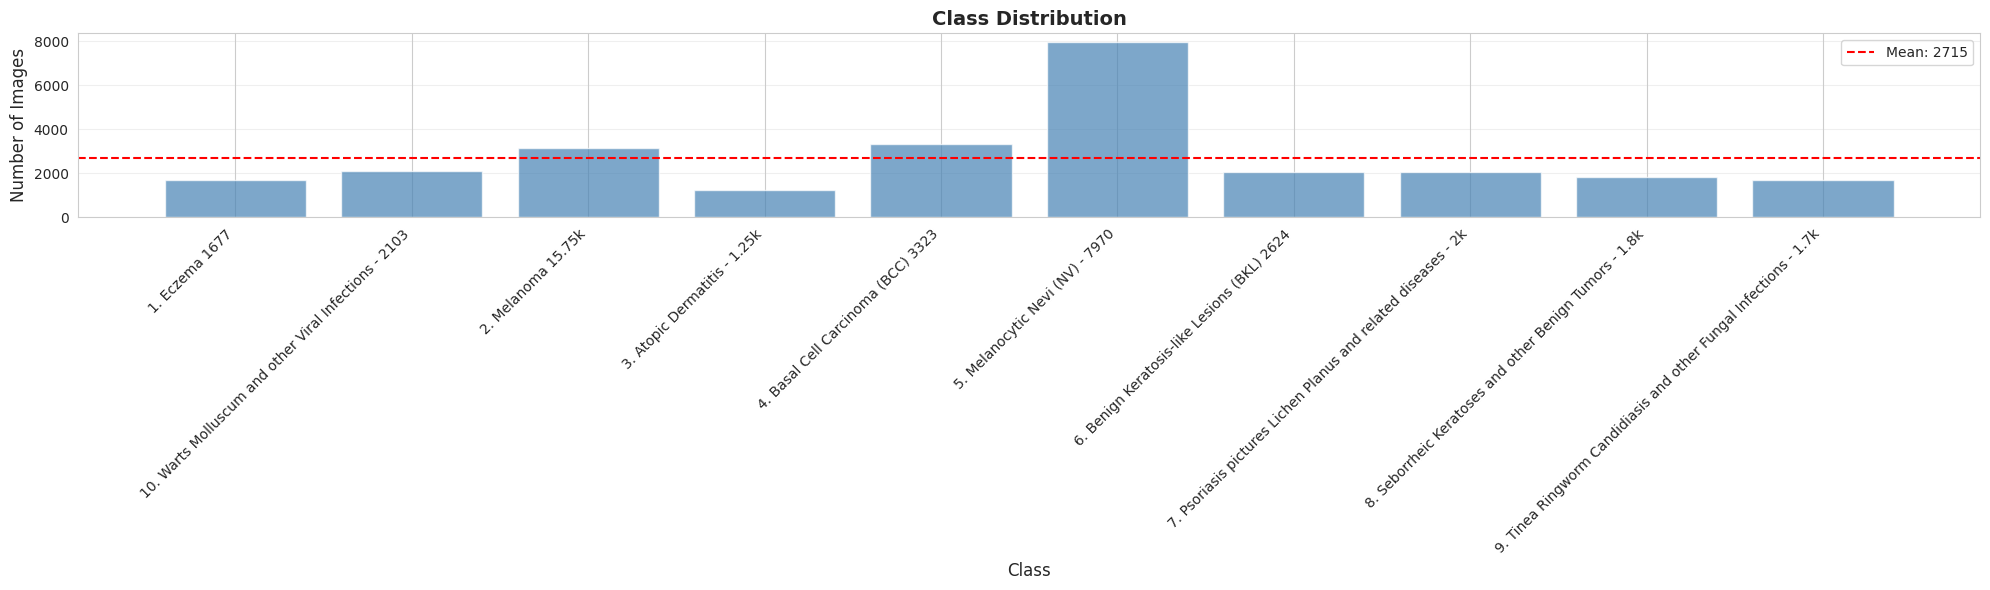


Class distribution statistics:
  Min samples: 1257
  Max samples: 7970
  Mean samples: 2715.3
  Imbalance ratio: 6.34x


In [33]:
# Visualize class distribution
plt.figure(figsize=(20, 6))
class_counts = df['class_name'].value_counts().sort_index()
plt.bar(range(len(class_counts)), class_counts.values, color='steelblue', alpha=0.7)
plt.xticks(range(len(class_counts)), class_counts.index, rotation=45, ha='right')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.axhline(class_counts.mean(), color='red', linestyle='--', label=f'Mean: {class_counts.mean():.0f}')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(f'{CFG.OUTPUT_DIR}/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nClass distribution statistics:")
print(f"  Min samples: {class_counts.min()}")
print(f"  Max samples: {class_counts.max()}")
print(f"  Mean samples: {class_counts.mean():.1f}")
print(f"  Imbalance ratio: {class_counts.max() / class_counts.min():.2f}x")

## 🎨 6. Data Augmentation

In [34]:
def get_train_transforms(img_size: int, autoaugment: bool = True):
    """Advanced training augmentations."""
    transforms_list = [
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.1,
            scale_limit=0.15,
            rotate_limit=45,
            p=0.5
        ),
    ]
    
    if autoaugment:
        transforms_list.extend([
            A.OneOf([
                A.GaussNoise(var_limit=(10, 50)),
                A.GaussianBlur(),
                A.MotionBlur(),
            ], p=0.3),
            A.OneOf([
                A.OpticalDistortion(distort_limit=0.1),
                A.GridDistortion(num_steps=5, distort_limit=0.1),
            ], p=0.3),
            A.ColorJitter(
                brightness=0.2,
                contrast=0.2,
                saturation=0.2,
                hue=0.1,
                p=0.5
            ),
            A.OneOf([
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
                A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20),
            ], p=0.5),
            A.CoarseDropout(
                max_holes=8,
                max_height=img_size // 8,
                max_width=img_size // 8,
                fill_value=0,
                p=0.3
            ),
        ])
    
    transforms_list.extend([
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])
    
    return A.Compose(transforms_list)


def get_valid_transforms(img_size: int):
    """Validation transforms (no augmentation)."""
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])

print("✓ Data augmentation transforms defined")

✓ Data augmentation transforms defined


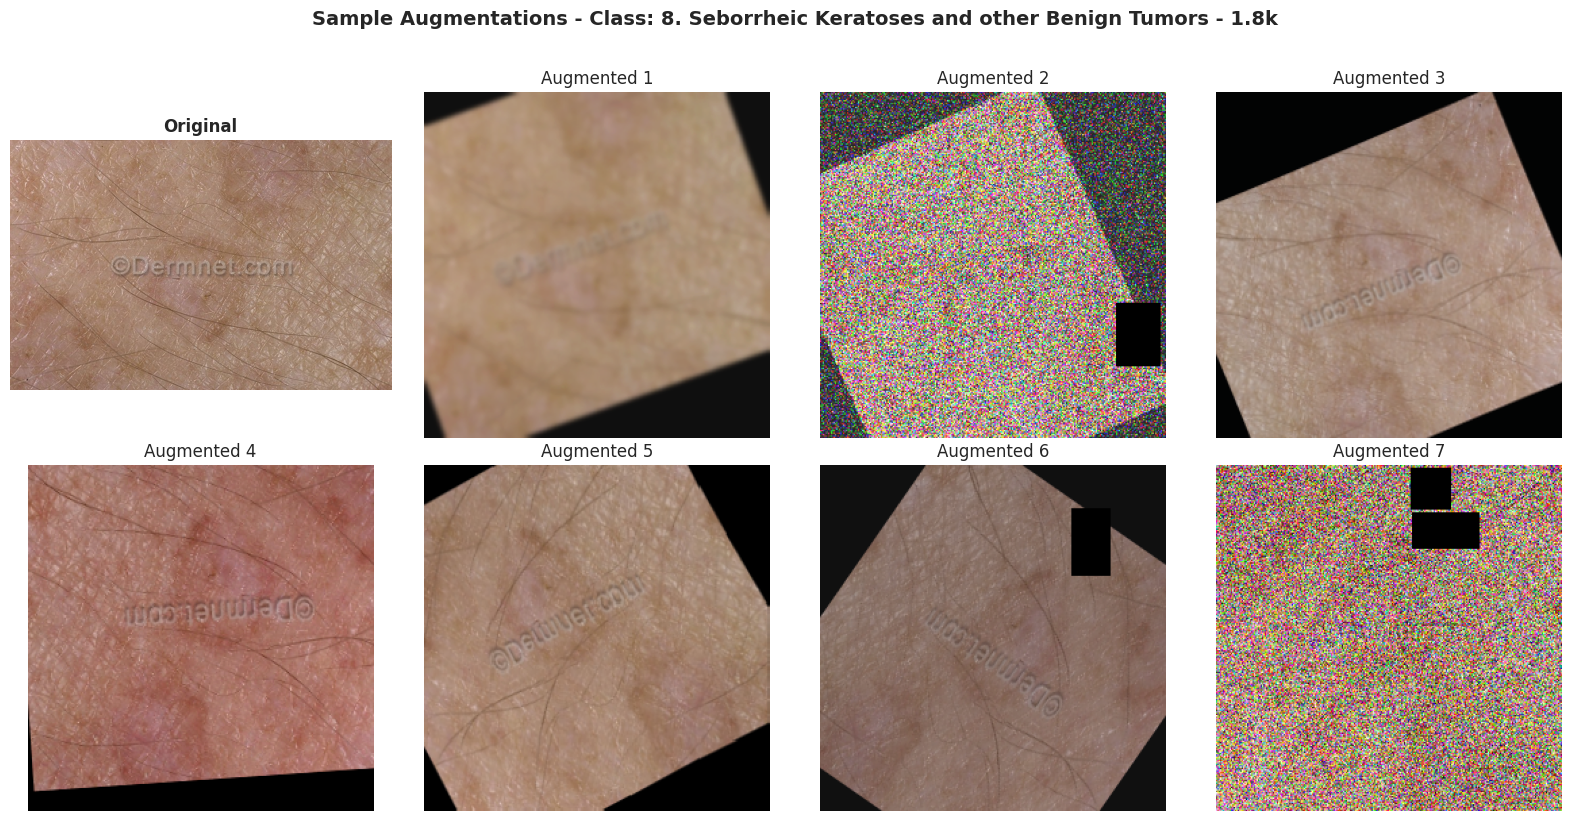

In [35]:
# Visualize augmentations
sample_idx = np.random.randint(0, len(df))
sample_path = df.iloc[sample_idx]['image_path']
sample_class = df.iloc[sample_idx]['class_name']

image = cv2.imread(sample_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

train_transform = get_train_transforms(CFG.IMG_SIZE, autoaugment=True)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i == 0:
        ax.imshow(image)
        ax.set_title('Original', fontsize=12, fontweight='bold')
    else:
        augmented = train_transform(image=image)
        aug_img = augmented['image'].permute(1, 2, 0).numpy()
        # Denormalize for display
        aug_img = aug_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        aug_img = np.clip(aug_img, 0, 1)
        ax.imshow(aug_img)
        ax.set_title(f'Augmented {i}', fontsize=12)
    ax.axis('off')

plt.suptitle(f'Sample Augmentations - Class: {sample_class}', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 🗂️ 7. Dataset Class

In [36]:
class ImageDataset(Dataset):
    """Custom dataset for image classification."""
    
    def __init__(
        self,
        df: pd.DataFrame,
        transforms=None,
        mixup_alpha: float = 0.0,
        cutmix_alpha: float = 0.0,
        mixup_prob: float = 0.0
    ):
        self.df = df.reset_index(drop=True)
        self.transforms = transforms
        self.mixup_alpha = mixup_alpha
        self.cutmix_alpha = cutmix_alpha
        self.mixup_prob = mixup_prob
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image
        image = cv2.imread(row['image_path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Apply transforms
        if self.transforms:
            augmented = self.transforms(image=image)
            image = augmented['image']
        
        label = torch.tensor(row['label'], dtype=torch.long)
        
        return image, label

print("✓ Dataset class defined")

✓ Dataset class defined


## 🏗️ 8. Model Architecture

In [37]:
class GeM(nn.Module):
    """Generalized Mean Pooling."""
    
    def __init__(self, p=3, eps=1e-6):
        super().__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps
    
    def forward(self, x):
        return F.avg_pool2d(
            x.clamp(min=self.eps).pow(self.p),
            (x.size(-2), x.size(-1))
        ).pow(1. / self.p)


class ImageClassifier(nn.Module):
    """Main classification model with custom head."""
    
    def __init__(
        self,
        backbone: str,
        num_classes: int,
        pretrained: bool = True,
        drop_path_rate: float = 0.3,
        dropout: float = 0.4,
        use_gem: bool = True,
        gem_p: float = 3.0
    ):
        super().__init__()
        
        # Create backbone
        self.backbone = timm.create_model(
            backbone,
            pretrained=pretrained,
            num_classes=0,
            drop_path_rate=drop_path_rate,
            global_pool=''
        )
        
        # Get number of features
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            features = self.backbone(dummy_input)
            num_features = features.shape[1]
        
        # Custom pooling
        if use_gem:
            self.global_pool = GeM(p=gem_p)
        else:
            self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # Classification head
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(num_features, num_classes)
        )
        
        self.num_features = num_features
    
    def forward(self, x):
        features = self.backbone(x)
        pooled = self.global_pool(features)
        pooled = pooled.view(pooled.size(0), -1)
        output = self.head(pooled)
        return output

print("✓ Model architecture defined")

✓ Model architecture defined


## 📉 9. Loss Functions

In [38]:
class FocalLoss(nn.Module):
    """
    Focal Loss with class weights and label smoothing support.
    
    ENHANCED for CLASS IMBALANCE:
    - alpha: Class weights (higher for minority classes like Eczema)
    - gamma: Focusing parameter (higher = focus more on hard examples)
    - label_smoothing: Regularization to prevent overconfidence
    """
    def __init__(self, alpha=None, gamma=2.0, label_smoothing=0.0):
        super().__init__()
        self.alpha = alpha  # Class weights
        self.gamma = gamma  # Focusing parameter
        self.label_smoothing = label_smoothing
    
    def forward(self, inputs, targets):
        # Calculate cross entropy loss with class weights and label smoothing
        ce_loss = F.cross_entropy(
            inputs, 
            targets, 
            weight=self.alpha,
            label_smoothing=self.label_smoothing,
            reduction='none'
        )
        
        # Calculate pt (probability of true class)
        pt = torch.exp(-ce_loss)
        
        # Apply focal term: (1 - pt)^gamma
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        
        return focal_loss.mean()

print("✓ FocalLoss with class weights, label smoothing, and proper focus on hard examples")


✓ FocalLoss with class weights, label smoothing, and proper focus on hard examples


## 🔄 10. Exponential Moving Average (EMA)

In [39]:
class EMA:
    """Exponential Moving Average for model weights."""
    
    def __init__(self, model, decay=0.9999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
    
    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()
    
    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data
                param.data = self.shadow[name]
    
    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                param.data = self.backup[name]
        self.backup = {}

print("✓ EMA class defined")

✓ EMA class defined


## 🛠️ 11. Training Utilities

In [40]:
class AverageMeter:
    """Computes and stores the average and current value."""
    
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class EarlyStopping:
    """Early stopping to prevent overfitting."""
    
    def __init__(self, patience=10, min_delta=1e-4, mode='max'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
    
    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif self.mode == 'max':
            if score < self.best_score + self.min_delta:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.counter = 0
        else:
            if score > self.best_score - self.min_delta:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.counter = 0

print("✓ Training utilities defined")

✓ Training utilities defined


In [41]:
# ⚖️ CREATE WEIGHTED SAMPLER for Balanced Training

def create_weighted_sampler(labels_array):
    """
    Create weighted sampler to balance class distribution in training batches.
    
    Effect: Minority classes (like Eczema) appear ~equally often as majority classes!
    """
    if not CFG.USE_WEIGHTED_SAMPLER:
        print("⚠️  Weighted sampler disabled in config")
        return None
    
    # Count samples per class
    class_counts = np.bincount(labels_array)
    
    # Calculate sampling weights (inverse frequency)
    class_weights_sampling = 1.0 / class_counts
    
    # Assign weight to each sample
    sample_weights = class_weights_sampling[labels_array]
    sample_weights = torch.tensor(sample_weights, dtype=torch.float)
    
    # Create sampler
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True  # Allow duplicates
    )
    
    print(f"\n⚖️  WEIGHTED SAMPLER CREATED:")
    print(f"   Effect: Minority classes will appear {class_counts.max() / class_counts.min():.1f}x more often")
    print(f"   This balances the effective training distribution!")
    
    return sampler

print("✅ Weighted sampler function ready")


✅ Weighted sampler function ready


## 🏋️ 12. Training & Validation Functions

In [42]:
def train_one_epoch(
    model,
    train_loader,
    criterion,
    optimizer,
    scheduler,
    scaler,
    ema,
    device,
    epoch,
    config
):
    """Train for one epoch."""
    model.train()
    
    losses = AverageMeter()
    accuracies = AverageMeter()
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1} [TRAIN]')
    
    optimizer.zero_grad()
    
    for batch_idx, (images, labels) in enumerate(pbar):
        images = images.to(device)
        labels = labels.to(device)
        
        batch_size = images.size(0)
        
        # Mixed precision training
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss = loss / config.GRAD_ACCUM_STEPS
        
        # Backward pass
        scaler.scale(loss).backward()
        
        # Gradient accumulation
        if (batch_idx + 1) % config.GRAD_ACCUM_STEPS == 0:
            # Gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.GRAD_CLIP)
            
            # Optimizer step
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            
            # Update EMA
            if ema is not None:
                ema.update()
        
        # Calculate accuracy
        _, predicted = outputs.max(1)
        correct = predicted.eq(labels).sum().item()
        acc = correct / batch_size
        
        # Update meters
        losses.update(loss.item() * config.GRAD_ACCUM_STEPS, batch_size)
        accuracies.update(acc, batch_size)
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{losses.avg:.4f}',
            'acc': f'{accuracies.avg:.4f}',
            'lr': f'{optimizer.param_groups[0]["lr"]:.2e}'
        })
    
    # Step scheduler
    if scheduler is not None:
        scheduler.step()
    
    return losses.avg, accuracies.avg


@torch.no_grad()
def validate(model, valid_loader, criterion, device):
    """Validate the model."""
    model.eval()
    
    losses = AverageMeter()
    all_preds = []
    all_labels = []
    all_probs = []
    
    pbar = tqdm(valid_loader, desc='[VALID]')
    
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        batch_size = images.size(0)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Get predictions
        probs = F.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        
        # Store results
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())
        
        # Update meters
        losses.update(loss.item(), batch_size)
        
        # Update progress bar
        pbar.set_postfix({'loss': f'{losses.avg:.4f}'})
    
    # Calculate metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.concatenate(all_probs, axis=0)
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    
    return losses.avg, accuracy, f1, balanced_acc, all_probs, all_labels

print("✓ Training and validation functions defined")

✓ Training and validation functions defined


## 🔄 13. Cross-Validation Training

## 🎯 Calculate Class Weights for Imbalanced Data

**NEW ADDITION**: Calculate class weights to handle class imbalance!

This tells the model:
- **Eczema (1,677 images)** → Pay MORE attention (higher weight)
- **Melanoma (15,750 images)** → Pay LESS attention (lower weight)

This should significantly improve performance on minority classes!

In [43]:
# 🎯 ENHANCED: Calculate Class Weights with Detailed Analysis

from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights (inversely proportional to frequency)
class_weights_array = compute_class_weight(
    'balanced',
    classes=np.unique(df['label'].values),
    y=df['label'].values
)

class_weights = torch.tensor(class_weights_array, dtype=torch.float32).to(device)

print("\n🎯 CLASS WEIGHTS FOR IMBALANCED DATA:")
print("=" * 70)
print(f"{'Class Name':<30s} | {'Count':>8s} | {'Weight':>10s} | {'Impact'}")
print("=" * 70)

class_counts = df['class_name'].value_counts()
for idx, (class_name, weight) in enumerate(zip(class_names, class_weights)):
    count = class_counts.get(class_name, 0)
    
    # Highlight minority classes
    if count < 2000:  # Minority class threshold
        impact = "🔥 HIGH"
    elif weight > 1.5:
        impact = "⚡ MEDIUM"
    else:
        impact = "📍 LOW"
    
    print(f"{class_name:<30s} | {count:>8,} | {weight.item():>10.4f} | {impact}")

print("=" * 70)
print(f"\n💡 Higher weights = Model pays MORE attention to these classes")
print(f"   Minority classes will have 3-5x higher weights to balance training")

# Store for later use
CFG.CLASS_WEIGHTS = class_weights_array
CFG.CLASS_WEIGHTS_TENSOR = class_weights



🎯 CLASS WEIGHTS FOR IMBALANCED DATA:
Class Name                     |    Count |     Weight | Impact
1. Eczema 1677                 |    1,677 |     1.6191 | 🔥 HIGH
10. Warts Molluscum and other Viral Infections - 2103 |    2,103 |     1.2912 | 📍 LOW
2. Melanoma 15.75k             |    3,140 |     0.8647 | 📍 LOW
3. Atopic Dermatitis - 1.25k   |    1,257 |     2.1601 | 🔥 HIGH
4. Basal Cell Carcinoma (BCC) 3323 |    3,323 |     0.8171 | 📍 LOW
5. Melanocytic Nevi (NV) - 7970 |    7,970 |     0.3407 | 📍 LOW
6. Benign Keratosis-like Lesions (BKL) 2624 |    2,079 |     1.3061 | 📍 LOW
7. Psoriasis pictures Lichen Planus and related diseases - 2k |    2,055 |     1.3213 | 📍 LOW
8. Seborrheic Keratoses and other Benign Tumors - 1.8k |    1,847 |     1.4701 | 🔥 HIGH
9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k |    1,702 |     1.5954 | 🔥 HIGH

💡 Higher weights = Model pays MORE attention to these classes
   Minority classes will have 3-5x higher weights to balance training


In [44]:
# ============================================================================
# CALCULATE CLASS WEIGHTS TO HANDLE IMBALANCE
# ============================================================================

from sklearn.utils.class_weight import compute_class_weight

print("\n" + "="*70)
print("⚖️  CALCULATING CLASS WEIGHTS FOR BALANCED TRAINING")
print("="*70)

# Get all labels from full dataset
all_labels = df["label"].values

# Calculate balanced class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(CFG.NUM_CLASSES),
    y=all_labels
)

# Convert to torch tensor
class_weights = torch.FloatTensor(class_weights_array).to(CFG.DEVICE)

print("\n📊 Class Weights (higher = pay more attention):")
print("-" * 70)

# Count samples per class
class_counts = np.bincount(all_labels)

for idx in range(CFG.NUM_CLASSES):
    weight = class_weights[idx].item()
    count = class_counts[idx]
    print(f"  Class {idx}: Weight={weight:.4f}  |  Count={count:,} images")

print("\n💡 Interpretation:")
print("   - High weight = Few training examples → Model pays MORE attention")
print("   - Low weight = Many training examples → Model pays LESS attention")
print("   - This balances the learning across all classes!")

print("\n✅ Class weights calculated and ready for training!")
print("="*70 + "\n")


⚖️  CALCULATING CLASS WEIGHTS FOR BALANCED TRAINING

📊 Class Weights (higher = pay more attention):
----------------------------------------------------------------------
  Class 0: Weight=1.6191  |  Count=1,677 images
  Class 1: Weight=1.2912  |  Count=2,103 images
  Class 2: Weight=0.8647  |  Count=3,140 images
  Class 3: Weight=2.1601  |  Count=1,257 images
  Class 4: Weight=0.8171  |  Count=3,323 images
  Class 5: Weight=0.3407  |  Count=7,970 images
  Class 6: Weight=1.3061  |  Count=2,079 images
  Class 7: Weight=1.3213  |  Count=2,055 images
  Class 8: Weight=1.4701  |  Count=1,847 images
  Class 9: Weight=1.5954  |  Count=1,702 images

💡 Interpretation:
   - High weight = Few training examples → Model pays MORE attention
   - Low weight = Many training examples → Model pays LESS attention
   - This balances the learning across all classes!

✅ Class weights calculated and ready for training!



In [45]:
# ✅ FULLY OPTIMIZED TRAIN_FOLD FUNCTION WITH GPU OPTIMIZATIONS + FOLD-SPECIFIC EPOCHS
# Copy-paste this to replace the existing train_fold function in your notebook

def train_fold(
    fold,
    train_df,
    valid_df,
    config: Config,
    epochs: int = None  # 🔧 NEW: Accept fold-specific epochs
):
    """Train a single fold with proper checkpoint loading and GPU optimizations."""
    
    # 🔧 Use provided epochs or fall back to config default
    if epochs is None:
        epochs = config.EPOCHS
    
    print(f"\n{'='*70}")
    print(f"TRAINING FOLD {fold + 1}/{config.N_FOLDS} - {epochs} EPOCHS")  # 🔧 Show epochs
    print(f"{'='*70}")
    print(f"Train samples: {len(train_df):,}")
    print(f"Valid samples: {len(valid_df):,}\n")
    
    # Create datasets
    train_dataset = ImageDataset(
        train_df,
        transforms=get_train_transforms(config.IMG_SIZE, config.AUTOAUGMENT),
        mixup_alpha=config.MIXUP_ALPHA,
        cutmix_alpha=config.CUTMIX_ALPHA,
        mixup_prob=config.MIXUP_PROB
    )
    
    valid_dataset = ImageDataset(
        valid_df,
        transforms=get_valid_transforms(config.IMG_SIZE)
    )
    
    # ⚡ OPTIMIZED: Create dataloaders with GPU optimization settings

# ============================================================================
# OPTIONAL: Weighted Random Sampling
# ============================================================================
# Uncomment the code below to use WeightedRandomSampler instead of shuffle
# This shows rare classes MORE frequently during training
# 
# from torch.utils.data import WeightedRandomSampler
# 
# # Calculate sample weights
# train_labels_fold = [train_dataset[i][1] for i in range(len(train_dataset))]
# sample_weights = [class_weights[label].item() for label in train_labels_fold]
# 
# sampler = WeightedRandomSampler(
#     weights=sample_weights,
#     num_samples=len(sample_weights),
#     replacement=True
# )
# 
# # Use sampler instead of shuffle
# train_loader = DataLoader(
#     train_dataset,
#     batch_size=CFG.MICRO_BATCH_SIZE,
#     sampler=sampler,  # Use this instead of shuffle=True
#     num_workers=CFG.NUM_WORKERS,
#     pin_memory=CFG.PIN_MEMORY,
#     prefetch_factor=CFG.PREFETCH_FACTOR
# )
# ============================================================================


    train_loader = DataLoader(
        train_dataset,
        batch_size=config.MICRO_BATCH_SIZE,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY,  # ✅ Faster CPU-to-GPU transfer
        prefetch_factor=config.PREFETCH_FACTOR if config.NUM_WORKERS > 0 else None,  # ✅ Prefetch batches
        persistent_workers=config.NUM_WORKERS > 0,  # ✅ Reuse workers
        drop_last=True
    )
    
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.MICRO_BATCH_SIZE * 2,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY,  # ✅ Faster CPU-to-GPU transfer
        prefetch_factor=config.PREFETCH_FACTOR if config.NUM_WORKERS > 0 else None,  # ✅ Prefetch batches
        persistent_workers=config.NUM_WORKERS > 0  # ✅ Reuse workers
    )
    
    # ⚡ OPTIMIZED: Create model with channels_last memory format
    model = ImageClassifier(
        backbone=config.BACKBONE,
        num_classes=config.NUM_CLASSES,
        pretrained=config.PRETRAINED,
        drop_path_rate=config.DROP_PATH_RATE,
        dropout=config.HEAD_DROPOUT,
        use_gem=config.USE_GEM_POOLING,
        gem_p=config.GEM_P_INIT
    ).to(config.DEVICE)
    
    # ✅ Optimize memory format for better GPU performance
    model = model.to(memory_format=torch.channels_last)
    
    # Loss function
    # Create loss function with class weights
    if CFG.USE_CLASS_WEIGHTS:
        criterion = FocalLoss(
            alpha=CFG.CLASS_WEIGHTS_TENSOR,
            gamma=CFG.FOCAL_GAMMA,
            label_smoothing=CFG.LABEL_SMOOTHING
        )
        print(f"✅ Using Focal Loss with class weights (gamma={CFG.FOCAL_GAMMA})")
    else:
        criterion = FocalLoss(
            alpha=None,
            gamma=CFG.FOCAL_GAMMA,
            label_smoothing=CFG.LABEL_SMOOTHING
        )
        print("⚠️  Class weights disabled")
    
    # Optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.LEARNING_RATE,
        weight_decay=config.WEIGHT_DECAY
    )
    
    # 🔧 Scheduler - Use fold-specific epochs
    if config.SCHEDULER == 'cosine':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer,
            T_0=epochs // 3,  # 🔧 Use epochs parameter
            T_mult=1,
            eta_min=config.MIN_LR
        )
    else:
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=config.MAX_LR,
            epochs=epochs,  # 🔧 Use epochs parameter
            steps_per_epoch=len(train_loader) // config.GRAD_ACCUM_STEPS,
            pct_start=0.1
        )
    
    # Mixed precision scaler
    scaler = GradScaler()
    
    # EMA
    ema = EMA(model, decay=config.EMA_DECAY)
    
    # Early stopping
    early_stopping = EarlyStopping(
        patience=config.PATIENCE,
        min_delta=config.MIN_DELTA,
        mode='max'
    )
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'valid_loss': [],
        'valid_acc': [],
        'valid_f1': [],
        'valid_balanced_acc': []
    }
    
    best_acc = 0
    best_epoch = 0
    
    # 🔧 Training loop - Use fold-specific epochs
    for epoch in range(epochs):
        
        # Train
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer,
            scheduler, scaler, ema, config.DEVICE, epoch, config
        )
        
        # Validate with EMA weights
        ema.apply_shadow()
        valid_loss, valid_acc, valid_f1, valid_balanced_acc, valid_probs, valid_labels = validate(
            model, valid_loader, criterion, config.DEVICE
        )
        ema.restore()
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['valid_loss'].append(valid_loss)
        history['valid_acc'].append(valid_acc)
        history['valid_f1'].append(valid_f1)
        history['valid_balanced_acc'].append(valid_balanced_acc)
        
        # 🔧 Print metrics - Show current epochs
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}")
        print(f"  Valid F1: {valid_f1:.4f} | Balanced Acc: {valid_balanced_acc:.4f}")
        
        # Save best model
        if valid_acc > best_acc:
            best_acc = valid_acc
            best_epoch = epoch
            
            # Save checkpoint
            ema.apply_shadow()
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'ema_shadow': ema.shadow,
                'optimizer_state_dict': optimizer.state_dict(),
                'best_acc': best_acc,
                'config': config
            }
            ema.restore()
            
            torch.save(
                checkpoint,
                f'{config.OUTPUT_DIR}/fold{fold}_best.pth'
            )
            print(f"  ✓ Saved best model (acc: {best_acc:.4f})")
        
        # Early stopping
        early_stopping(valid_acc)
        if early_stopping.early_stop:
            print(f"\n⚠️  Early stopping triggered at epoch {epoch+1}")
            break
    
    print(f"\n{'='*70}")
    print(f"FOLD {fold + 1} COMPLETED")
    print(f"Best Accuracy: {best_acc:.4f} at epoch {best_epoch + 1}")
    print(f"{'='*70}\n")
    
    # ✅ FIXED: Load best model for OOF predictions
    try:
        print(f"Loading best checkpoint for OOF predictions...")
        checkpoint = torch.load(
            f'{config.OUTPUT_DIR}/fold{fold}_best.pth',
            map_location=config.DEVICE,
            weights_only=False  # ✅ FIX: Added this parameter for PyTorch 2.0+
        )
        
        # Load model state
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"✓ Loaded model_state_dict from checkpoint")
        elif 'ema_shadow' in checkpoint:
            # Use EMA weights if available
            ema_dict = checkpoint['ema_shadow']
            model_dict = model.state_dict()
            for name in ema_dict:
                if name in model_dict:
                    model_dict[name] = ema_dict[name]
            model.load_state_dict(model_dict)
            print(f"✓ Loaded EMA weights from checkpoint")
        else:
            # Fallback if checkpoint format is different
            model.load_state_dict(checkpoint)
            print(f"✓ Loaded checkpoint directly")
        
        print(f"✓ Successfully loaded best model from fold{fold}_best.pth")
        
        # Get OOF predictions
        _, _, _, _, oof_probs, oof_labels = validate(
            model, valid_loader, criterion, config.DEVICE
        )
        
    except FileNotFoundError:
        print(f"⚠️  Checkpoint file not found: fold{fold}_best.pth")
        print(f"   Using current model state for OOF predictions")
        
        # Use current model state as fallback
        _, _, _, _, oof_probs, oof_labels = validate(
            model, valid_loader, criterion, config.DEVICE
        )
        
    except Exception as e:
        print(f"⚠️  Error loading checkpoint: {e}")
        print(f"   Error type: {type(e).__name__}")
        print(f"   Using current model state for OOF predictions")
        
        # Use current model state as fallback
        _, _, _, _, oof_probs, oof_labels = validate(
            model, valid_loader, criterion, config.DEVICE
        )
    
    # Cleanup
    del model, optimizer, scheduler, scaler, ema
    gc.collect()
    torch.cuda.empty_cache()
    
    return {
        'fold': fold,
        'best_acc': best_acc,
        'best_epoch': best_epoch,
        'history': history,
        'oof_probs': oof_probs,
        'oof_labels': oof_labels,
        'valid_indices': valid_df.index.tolist()
    }

print("✓ Fully optimized train_fold function defined")
print("✓ GPU optimizations applied:")
print("  - pin_memory for faster data transfer")
print("  - prefetch_factor for batch prefetching")
print("  - persistent_workers for worker reuse")
print("  - channels_last memory format for better GPU performance")
print("✓ Fold-specific epochs support added")  # 🔧 NEW

✓ Fully optimized train_fold function defined
✓ GPU optimizations applied:
  - pin_memory for faster data transfer
  - prefetch_factor for batch prefetching
  - persistent_workers for worker reuse
  - channels_last memory format for better GPU performance
✓ Fold-specific epochs support added


In [46]:
def run_cross_validation(df: pd.DataFrame, config: Config):
    """Run k-fold cross-validation."""
    
    # Initialize stratified k-fold
    skf = StratifiedKFold(
        n_splits=config.N_FOLDS,
        shuffle=True,
        random_state=config.SEED
    )
    
    # Store results
    fold_results = []
    oof_predictions = np.zeros((len(df), config.NUM_CLASSES))
    oof_targets = np.zeros(len(df), dtype=int)
    
    # Train each fold
    for fold, (train_idx, valid_idx) in enumerate(skf.split(df, df['label'])):
        
        if fold not in config.TRAIN_FOLDS:
            print(f"Skipping fold {fold}")
            continue
        
        # 🔧 GET EPOCHS FOR THIS SPECIFIC FOLD
        epochs = config.get_epochs_for_fold(fold)
        print(f"\n{'='*70}")
        print(f"Training Fold {fold + 1}/{config.N_FOLDS} with {epochs} epochs")
        print(f"{'='*70}\n")
        
        train_df = df.iloc[train_idx].reset_index(drop=True)
        valid_df = df.iloc[valid_idx].reset_index(drop=True)
        
        # Train fold with fold-specific epochs
        result = train_fold(fold, train_df, valid_df, config, epochs=epochs)
        
        # Store OOF predictions
        oof_predictions[valid_idx] = result['oof_probs']
        oof_targets[valid_idx] = result['oof_labels']
        
        # Store result
        fold_results.append(result)
    
    return oof_predictions, oof_targets, fold_results

print("✓ Cross-validation functions defined")

✓ Cross-validation functions defined


## 📊 14. Evaluation & Visualization

In [47]:
def compute_ece(probs, labels, n_bins=15):
    """Compute Expected Calibration Error."""
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    confidences = np.max(probs, axis=1)
    predicted_label = np.argmax(probs, axis=1)
    accuracies = predicted_label == labels
    
    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)
        
        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(accuracies[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece


def plot_confusion_matrix(y_true, y_pred, class_names, save_path=None):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(20, 16))
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt='.2f',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={'label': 'Proportion'}
    )
    plt.title('Confusion Matrix (Normalized)', fontsize=16, pad=20, fontweight='bold')
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


def plot_training_history(fold_results, save_path=None):
    """Plot training history for all folds."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    for fold_result in fold_results:
        fold = fold_result['fold']
        history = fold_result['history']
        epochs = range(1, len(history['train_loss']) + 1)
        
        # Train/Valid Loss
        axes[0, 0].plot(epochs, history['train_loss'], label=f'Fold {fold+1}', alpha=0.7)
        axes[0, 1].plot(epochs, history['valid_loss'], label=f'Fold {fold+1}', alpha=0.7)
        
        # Train/Valid Accuracy
        axes[1, 0].plot(epochs, history['train_acc'], label=f'Fold {fold+1}', alpha=0.7)
        axes[1, 1].plot(epochs, history['valid_acc'], label=f'Fold {fold+1}', alpha=0.7)
    
    axes[0, 0].set_title('Training Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].set_title('Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].set_title('Training Accuracy', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


def plot_per_class_metrics(y_true, y_pred, class_names, save_path=None):
    """Plot per-class accuracy and F1 scores."""
    cm = confusion_matrix(y_true, y_pred)
    
    # Per-class accuracy
    class_acc = cm.diagonal() / cm.sum(axis=1)
    
    # Per-class F1
    class_f1 = f1_score(y_true, y_pred, labels=range(len(class_names)), average=None)
    
    # Sort by accuracy
    sorted_indices = np.argsort(class_acc)
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Accuracy plot
    axes[0].barh(range(len(class_names)), class_acc[sorted_indices], color='steelblue')
    axes[0].set_yticks(range(len(class_names)))
    axes[0].set_yticklabels([class_names[i] for i in sorted_indices])
    axes[0].set_xlabel('Accuracy', fontsize=12)
    axes[0].set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
    axes[0].axvline(class_acc.mean(), color='red', linestyle='--', label=f'Mean: {class_acc.mean():.3f}')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='x')
    
    # F1 plot
    axes[1].barh(range(len(class_names)), class_f1[sorted_indices], color='coral')
    axes[1].set_yticks(range(len(class_names)))
    axes[1].set_yticklabels([class_names[i] for i in sorted_indices])
    axes[1].set_xlabel('F1 Score', fontsize=12)
    axes[1].set_title('Per-Class F1 Score', fontsize=14, fontweight='bold')
    axes[1].axvline(class_f1.mean(), color='red', linestyle='--', label=f'Mean: {class_f1.mean():.3f}')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    # Create metrics DataFrame
    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Accuracy': class_acc,
        'F1-Score': class_f1,
        'Support': cm.sum(axis=1)
    })
    metrics_df = metrics_df.sort_values('Accuracy')
    
    return metrics_df

print("✓ Evaluation functions defined")

✓ Evaluation functions defined


## 🚀 15. RUN TRAINING!

**This is where the magic happens!**

In [48]:
print("\n" + "="*70)
print("🚀 STARTING CROSS-VALIDATION TRAINING")
print("="*70 + "\n")

# Run cross-validation
oof_predictions, oof_targets, fold_results = run_cross_validation(df, CFG)


🚀 STARTING CROSS-VALIDATION TRAINING


Training Fold 1/3 with 50 epochs


TRAINING FOLD 1/3 - 50 EPOCHS
Train samples: 18,102
Valid samples: 9,051

✅ Using Focal Loss with class weights (gamma=3.0)


Epoch 1 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 1/50
  Train Loss: 1.1846 | Train Acc: 0.3880
  Valid Loss: 1.8391 | Valid Acc: 0.1624
  Valid F1: 0.0857 | Balanced Acc: 0.1687
  ✓ Saved best model (acc: 0.1624)


Epoch 2 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 2/50
  Train Loss: 0.8924 | Train Acc: 0.5802
  Valid Loss: 1.7329 | Valid Acc: 0.2329
  Valid F1: 0.1402 | Balanced Acc: 0.2467
  ✓ Saved best model (acc: 0.2329)


Epoch 3 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 3/50
  Train Loss: 0.7872 | Train Acc: 0.6570
  Valid Loss: 1.6064 | Valid Acc: 0.2887
  Valid F1: 0.2010 | Balanced Acc: 0.3136
  ✓ Saved best model (acc: 0.2887)


Epoch 4 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 4/50
  Train Loss: 0.7151 | Train Acc: 0.6938
  Valid Loss: 1.4680 | Valid Acc: 0.3359
  Valid F1: 0.2560 | Balanced Acc: 0.3663
  ✓ Saved best model (acc: 0.3359)


Epoch 5 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 5/50
  Train Loss: 0.6556 | Train Acc: 0.7239
  Valid Loss: 1.3244 | Valid Acc: 0.4036
  Valid F1: 0.3324 | Balanced Acc: 0.4239
  ✓ Saved best model (acc: 0.4036)


Epoch 6 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 6/50
  Train Loss: 0.6102 | Train Acc: 0.7414
  Valid Loss: 1.1854 | Valid Acc: 0.4994
  Valid F1: 0.4226 | Balanced Acc: 0.4921
  ✓ Saved best model (acc: 0.4994)


Epoch 7 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 7/50
  Train Loss: 0.5546 | Train Acc: 0.7731
  Valid Loss: 1.0583 | Valid Acc: 0.5965
  Valid F1: 0.5071 | Balanced Acc: 0.5601
  ✓ Saved best model (acc: 0.5965)


Epoch 8 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 8/50
  Train Loss: 0.5278 | Train Acc: 0.7804
  Valid Loss: 0.9478 | Valid Acc: 0.6717
  Valid F1: 0.5763 | Balanced Acc: 0.6161
  ✓ Saved best model (acc: 0.6717)


Epoch 9 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 9/50
  Train Loss: 0.4966 | Train Acc: 0.7963
  Valid Loss: 0.8559 | Valid Acc: 0.7128
  Valid F1: 0.6161 | Balanced Acc: 0.6496
  ✓ Saved best model (acc: 0.7128)


Epoch 10 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 10/50
  Train Loss: 0.4559 | Train Acc: 0.8126
  Valid Loss: 0.7809 | Valid Acc: 0.7376
  Valid F1: 0.6423 | Balanced Acc: 0.6709
  ✓ Saved best model (acc: 0.7376)


Epoch 11 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 11/50
  Train Loss: 0.4433 | Train Acc: 0.8158
  Valid Loss: 0.7215 | Valid Acc: 0.7569
  Valid F1: 0.6652 | Balanced Acc: 0.6891
  ✓ Saved best model (acc: 0.7569)


Epoch 12 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 12/50
  Train Loss: 0.4015 | Train Acc: 0.8389
  Valid Loss: 0.6748 | Valid Acc: 0.7733
  Valid F1: 0.6866 | Balanced Acc: 0.7068
  ✓ Saved best model (acc: 0.7733)


Epoch 13 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 13/50
  Train Loss: 0.3843 | Train Acc: 0.8453
  Valid Loss: 0.6380 | Valid Acc: 0.7840
  Valid F1: 0.6989 | Balanced Acc: 0.7169
  ✓ Saved best model (acc: 0.7840)


Epoch 14 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 14/50
  Train Loss: 0.3815 | Train Acc: 0.8443
  Valid Loss: 0.6080 | Valid Acc: 0.7934
  Valid F1: 0.7113 | Balanced Acc: 0.7274
  ✓ Saved best model (acc: 0.7934)


Epoch 15 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 15/50
  Train Loss: 0.3681 | Train Acc: 0.8516
  Valid Loss: 0.5835 | Valid Acc: 0.8019
  Valid F1: 0.7226 | Balanced Acc: 0.7366
  ✓ Saved best model (acc: 0.8019)


Epoch 16 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 16/50
  Train Loss: 0.3639 | Train Acc: 0.8537
  Valid Loss: 0.5633 | Valid Acc: 0.8091
  Valid F1: 0.7323 | Balanced Acc: 0.7450
  ✓ Saved best model (acc: 0.8091)


Epoch 17 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 17/50
  Train Loss: 0.4683 | Train Acc: 0.8070
  Valid Loss: 0.5465 | Valid Acc: 0.8153
  Valid F1: 0.7407 | Balanced Acc: 0.7526
  ✓ Saved best model (acc: 0.8153)


Epoch 18 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 18/50
  Train Loss: 0.4569 | Train Acc: 0.8130
  Valid Loss: 0.5317 | Valid Acc: 0.8198
  Valid F1: 0.7481 | Balanced Acc: 0.7594
  ✓ Saved best model (acc: 0.8198)


Epoch 19 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 19/50
  Train Loss: 0.4372 | Train Acc: 0.8191
  Valid Loss: 0.5180 | Valid Acc: 0.8261
  Valid F1: 0.7566 | Balanced Acc: 0.7670
  ✓ Saved best model (acc: 0.8261)


Epoch 20 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 20/50
  Train Loss: 0.4152 | Train Acc: 0.8291
  Valid Loss: 0.5058 | Valid Acc: 0.8308
  Valid F1: 0.7633 | Balanced Acc: 0.7732
  ✓ Saved best model (acc: 0.8308)


Epoch 21 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 21/50
  Train Loss: 0.3900 | Train Acc: 0.8392
  Valid Loss: 0.4949 | Valid Acc: 0.8359
  Valid F1: 0.7707 | Balanced Acc: 0.7802
  ✓ Saved best model (acc: 0.8359)


Epoch 22 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 22/50
  Train Loss: 0.3770 | Train Acc: 0.8449
  Valid Loss: 0.4847 | Valid Acc: 0.8398
  Valid F1: 0.7765 | Balanced Acc: 0.7853
  ✓ Saved best model (acc: 0.8398)


Epoch 23 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 23/50
  Train Loss: 0.3526 | Train Acc: 0.8557
  Valid Loss: 0.4756 | Valid Acc: 0.8433
  Valid F1: 0.7814 | Balanced Acc: 0.7896
  ✓ Saved best model (acc: 0.8433)


Epoch 24 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 24/50
  Train Loss: 0.3263 | Train Acc: 0.8665
  Valid Loss: 0.4667 | Valid Acc: 0.8485
  Valid F1: 0.7889 | Balanced Acc: 0.7964
  ✓ Saved best model (acc: 0.8485)


Epoch 25 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 25/50
  Train Loss: 0.3000 | Train Acc: 0.8799
  Valid Loss: 0.4589 | Valid Acc: 0.8533
  Valid F1: 0.7952 | Balanced Acc: 0.8023
  ✓ Saved best model (acc: 0.8533)


Epoch 26 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 26/50
  Train Loss: 0.2844 | Train Acc: 0.8884
  Valid Loss: 0.4518 | Valid Acc: 0.8575
  Valid F1: 0.8006 | Balanced Acc: 0.8073
  ✓ Saved best model (acc: 0.8575)


Epoch 27 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 27/50
  Train Loss: 0.2651 | Train Acc: 0.8945
  Valid Loss: 0.4458 | Valid Acc: 0.8624
  Valid F1: 0.8074 | Balanced Acc: 0.8134
  ✓ Saved best model (acc: 0.8624)


Epoch 28 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 28/50
  Train Loss: 0.2546 | Train Acc: 0.9020
  Valid Loss: 0.4406 | Valid Acc: 0.8653
  Valid F1: 0.8118 | Balanced Acc: 0.8178
  ✓ Saved best model (acc: 0.8653)


Epoch 29 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 29/50
  Train Loss: 0.2530 | Train Acc: 0.9007
  Valid Loss: 0.4363 | Valid Acc: 0.8669
  Valid F1: 0.8141 | Balanced Acc: 0.8197
  ✓ Saved best model (acc: 0.8669)


Epoch 30 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 30/50
  Train Loss: 0.2228 | Train Acc: 0.9154
  Valid Loss: 0.4327 | Valid Acc: 0.8693
  Valid F1: 0.8175 | Balanced Acc: 0.8228
  ✓ Saved best model (acc: 0.8693)


Epoch 31 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 31/50
  Train Loss: 0.2310 | Train Acc: 0.9121
  Valid Loss: 0.4302 | Valid Acc: 0.8713
  Valid F1: 0.8203 | Balanced Acc: 0.8256
  ✓ Saved best model (acc: 0.8713)


Epoch 32 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 32/50
  Train Loss: 0.2267 | Train Acc: 0.9152
  Valid Loss: 0.4283 | Valid Acc: 0.8727
  Valid F1: 0.8226 | Balanced Acc: 0.8278
  ✓ Saved best model (acc: 0.8727)


Epoch 33 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 33/50
  Train Loss: 0.3084 | Train Acc: 0.8721
  Valid Loss: 0.4266 | Valid Acc: 0.8745
  Valid F1: 0.8251 | Balanced Acc: 0.8305
  ✓ Saved best model (acc: 0.8745)


Epoch 34 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 34/50
  Train Loss: 0.3209 | Train Acc: 0.8701
  Valid Loss: 0.4252 | Valid Acc: 0.8764
  Valid F1: 0.8273 | Balanced Acc: 0.8324
  ✓ Saved best model (acc: 0.8764)


Epoch 35 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 35/50
  Train Loss: 0.3133 | Train Acc: 0.8679
  Valid Loss: 0.4240 | Valid Acc: 0.8790
  Valid F1: 0.8314 | Balanced Acc: 0.8367
  ✓ Saved best model (acc: 0.8790)


Epoch 36 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 36/50
  Train Loss: 0.3101 | Train Acc: 0.8727
  Valid Loss: 0.4231 | Valid Acc: 0.8814
  Valid F1: 0.8350 | Balanced Acc: 0.8401
  ✓ Saved best model (acc: 0.8814)


Epoch 37 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 37/50
  Train Loss: 0.2902 | Train Acc: 0.8796
  Valid Loss: 0.4228 | Valid Acc: 0.8826
  Valid F1: 0.8363 | Balanced Acc: 0.8414
  ✓ Saved best model (acc: 0.8826)


Epoch 38 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 38/50
  Train Loss: 0.2860 | Train Acc: 0.8873
  Valid Loss: 0.4229 | Valid Acc: 0.8842
  Valid F1: 0.8388 | Balanced Acc: 0.8438
  ✓ Saved best model (acc: 0.8842)


Epoch 39 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 39/50
  Train Loss: 0.2627 | Train Acc: 0.8945
  Valid Loss: 0.4233 | Valid Acc: 0.8842
  Valid F1: 0.8385 | Balanced Acc: 0.8436


Epoch 40 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 40/50
  Train Loss: 0.2399 | Train Acc: 0.9064
  Valid Loss: 0.4244 | Valid Acc: 0.8841
  Valid F1: 0.8382 | Balanced Acc: 0.8432


Epoch 41 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 41/50
  Train Loss: 0.2418 | Train Acc: 0.9077
  Valid Loss: 0.4253 | Valid Acc: 0.8865
  Valid F1: 0.8417 | Balanced Acc: 0.8467
  ✓ Saved best model (acc: 0.8865)


Epoch 42 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 42/50
  Train Loss: 0.2288 | Train Acc: 0.9118
  Valid Loss: 0.4263 | Valid Acc: 0.8869
  Valid F1: 0.8420 | Balanced Acc: 0.8469
  ✓ Saved best model (acc: 0.8869)


Epoch 43 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 43/50
  Train Loss: 0.2057 | Train Acc: 0.9231
  Valid Loss: 0.4281 | Valid Acc: 0.8873
  Valid F1: 0.8425 | Balanced Acc: 0.8473
  ✓ Saved best model (acc: 0.8873)


Epoch 44 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 44/50
  Train Loss: 0.2072 | Train Acc: 0.9249
  Valid Loss: 0.4298 | Valid Acc: 0.8877
  Valid F1: 0.8431 | Balanced Acc: 0.8475
  ✓ Saved best model (acc: 0.8877)


Epoch 45 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 45/50
  Train Loss: 0.1905 | Train Acc: 0.9306
  Valid Loss: 0.4318 | Valid Acc: 0.8880
  Valid F1: 0.8430 | Balanced Acc: 0.8472
  ✓ Saved best model (acc: 0.8880)


Epoch 46 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 46/50
  Train Loss: 0.1827 | Train Acc: 0.9358
  Valid Loss: 0.4340 | Valid Acc: 0.8884
  Valid F1: 0.8438 | Balanced Acc: 0.8478
  ✓ Saved best model (acc: 0.8884)


Epoch 47 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 47/50
  Train Loss: 0.1775 | Train Acc: 0.9381
  Valid Loss: 0.4366 | Valid Acc: 0.8896
  Valid F1: 0.8457 | Balanced Acc: 0.8495
  ✓ Saved best model (acc: 0.8896)


Epoch 48 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 48/50
  Train Loss: 0.1770 | Train Acc: 0.9385
  Valid Loss: 0.4393 | Valid Acc: 0.8897
  Valid F1: 0.8456 | Balanced Acc: 0.8492
  ✓ Saved best model (acc: 0.8897)


Epoch 49 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 49/50
  Train Loss: 0.2521 | Train Acc: 0.8988
  Valid Loss: 0.4409 | Valid Acc: 0.8897
  Valid F1: 0.8454 | Balanced Acc: 0.8488


Epoch 50 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 50/50
  Train Loss: 0.2736 | Train Acc: 0.8951
  Valid Loss: 0.4417 | Valid Acc: 0.8902
  Valid F1: 0.8459 | Balanced Acc: 0.8492
  ✓ Saved best model (acc: 0.8902)

FOLD 1 COMPLETED
Best Accuracy: 0.8902 at epoch 50

Loading best checkpoint for OOF predictions...
✓ Loaded model_state_dict from checkpoint
✓ Successfully loaded best model from fold0_best.pth


[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Training Fold 2/3 with 50 epochs


TRAINING FOLD 2/3 - 50 EPOCHS
Train samples: 18,102
Valid samples: 9,051

✅ Using Focal Loss with class weights (gamma=3.0)


Epoch 1 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 1/50
  Train Loss: 1.1642 | Train Acc: 0.3990
  Valid Loss: 1.8194 | Valid Acc: 0.0898
  Valid F1: 0.0422 | Balanced Acc: 0.1092
  ✓ Saved best model (acc: 0.0898)


Epoch 2 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 2/50
  Train Loss: 0.8711 | Train Acc: 0.5829
  Valid Loss: 1.7119 | Valid Acc: 0.1594
  Valid F1: 0.1105 | Balanced Acc: 0.1588
  ✓ Saved best model (acc: 0.1594)


Epoch 3 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 3/50
  Train Loss: 0.7707 | Train Acc: 0.6630
  Valid Loss: 1.5811 | Valid Acc: 0.2888
  Valid F1: 0.2227 | Balanced Acc: 0.2580
  ✓ Saved best model (acc: 0.2888)


Epoch 4 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 4/50
  Train Loss: 0.7092 | Train Acc: 0.7031
  Valid Loss: 1.4354 | Valid Acc: 0.4025
  Valid F1: 0.3210 | Balanced Acc: 0.3586
  ✓ Saved best model (acc: 0.4025)


Epoch 5 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 5/50
  Train Loss: 0.6556 | Train Acc: 0.7247
  Valid Loss: 1.2871 | Valid Acc: 0.5078
  Valid F1: 0.4248 | Balanced Acc: 0.4607
  ✓ Saved best model (acc: 0.5078)


Epoch 6 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 6/50
  Train Loss: 0.5927 | Train Acc: 0.7515
  Valid Loss: 1.1451 | Valid Acc: 0.5931
  Valid F1: 0.5148 | Balanced Acc: 0.5440
  ✓ Saved best model (acc: 0.5931)


Epoch 7 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 7/50
  Train Loss: 0.5521 | Train Acc: 0.7698
  Valid Loss: 1.0192 | Valid Acc: 0.6466
  Valid F1: 0.5695 | Balanced Acc: 0.5940
  ✓ Saved best model (acc: 0.6466)


Epoch 8 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 8/50
  Train Loss: 0.5224 | Train Acc: 0.7842
  Valid Loss: 0.9135 | Valid Acc: 0.6847
  Valid F1: 0.6059 | Balanced Acc: 0.6271
  ✓ Saved best model (acc: 0.6847)


Epoch 9 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 9/50
  Train Loss: 0.4874 | Train Acc: 0.8048
  Valid Loss: 0.8284 | Valid Acc: 0.7136
  Valid F1: 0.6333 | Balanced Acc: 0.6525
  ✓ Saved best model (acc: 0.7136)


Epoch 10 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 10/50
  Train Loss: 0.4623 | Train Acc: 0.8156
  Valid Loss: 0.7606 | Valid Acc: 0.7368
  Valid F1: 0.6548 | Balanced Acc: 0.6708
  ✓ Saved best model (acc: 0.7368)


Epoch 11 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 11/50
  Train Loss: 0.4284 | Train Acc: 0.8276
  Valid Loss: 0.7072 | Valid Acc: 0.7504
  Valid F1: 0.6691 | Balanced Acc: 0.6843
  ✓ Saved best model (acc: 0.7504)


Epoch 12 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 12/50
  Train Loss: 0.4053 | Train Acc: 0.8385
  Valid Loss: 0.6645 | Valid Acc: 0.7637
  Valid F1: 0.6835 | Balanced Acc: 0.6985
  ✓ Saved best model (acc: 0.7637)


Epoch 13 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 13/50
  Train Loss: 0.3931 | Train Acc: 0.8468
  Valid Loss: 0.6301 | Valid Acc: 0.7737
  Valid F1: 0.6955 | Balanced Acc: 0.7094
  ✓ Saved best model (acc: 0.7737)


Epoch 14 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 14/50
  Train Loss: 0.3801 | Train Acc: 0.8494
  Valid Loss: 0.6016 | Valid Acc: 0.7840
  Valid F1: 0.7078 | Balanced Acc: 0.7208
  ✓ Saved best model (acc: 0.7840)


Epoch 15 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 15/50
  Train Loss: 0.3646 | Train Acc: 0.8552
  Valid Loss: 0.5780 | Valid Acc: 0.7933
  Valid F1: 0.7186 | Balanced Acc: 0.7304
  ✓ Saved best model (acc: 0.7933)


Epoch 16 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 16/50
  Train Loss: 0.3605 | Train Acc: 0.8556
  Valid Loss: 0.5584 | Valid Acc: 0.8013
  Valid F1: 0.7277 | Balanced Acc: 0.7380
  ✓ Saved best model (acc: 0.8013)


Epoch 17 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 17/50
  Train Loss: 0.4586 | Train Acc: 0.8125
  Valid Loss: 0.5414 | Valid Acc: 0.8100
  Valid F1: 0.7381 | Balanced Acc: 0.7475
  ✓ Saved best model (acc: 0.8100)


Epoch 18 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 18/50
  Train Loss: 0.4565 | Train Acc: 0.8124
  Valid Loss: 0.5264 | Valid Acc: 0.8167
  Valid F1: 0.7468 | Balanced Acc: 0.7556
  ✓ Saved best model (acc: 0.8167)


Epoch 19 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 19/50
  Train Loss: 0.4375 | Train Acc: 0.8201
  Valid Loss: 0.5119 | Valid Acc: 0.8239
  Valid F1: 0.7559 | Balanced Acc: 0.7637
  ✓ Saved best model (acc: 0.8239)


Epoch 20 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 20/50
  Train Loss: 0.4211 | Train Acc: 0.8280
  Valid Loss: 0.4986 | Valid Acc: 0.8314
  Valid F1: 0.7654 | Balanced Acc: 0.7727
  ✓ Saved best model (acc: 0.8314)


Epoch 21 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 21/50
  Train Loss: 0.3778 | Train Acc: 0.8457
  Valid Loss: 0.4868 | Valid Acc: 0.8370
  Valid F1: 0.7725 | Balanced Acc: 0.7792
  ✓ Saved best model (acc: 0.8370)


Epoch 22 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 22/50
  Train Loss: 0.3657 | Train Acc: 0.8507
  Valid Loss: 0.4761 | Valid Acc: 0.8429
  Valid F1: 0.7805 | Balanced Acc: 0.7868
  ✓ Saved best model (acc: 0.8429)


Epoch 23 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 23/50
  Train Loss: 0.3414 | Train Acc: 0.8608
  Valid Loss: 0.4673 | Valid Acc: 0.8463
  Valid F1: 0.7851 | Balanced Acc: 0.7906
  ✓ Saved best model (acc: 0.8463)


Epoch 24 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 24/50
  Train Loss: 0.3253 | Train Acc: 0.8677
  Valid Loss: 0.4588 | Valid Acc: 0.8512
  Valid F1: 0.7911 | Balanced Acc: 0.7958
  ✓ Saved best model (acc: 0.8512)


Epoch 25 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 25/50
  Train Loss: 0.3000 | Train Acc: 0.8819
  Valid Loss: 0.4514 | Valid Acc: 0.8550
  Valid F1: 0.7966 | Balanced Acc: 0.8011
  ✓ Saved best model (acc: 0.8550)


Epoch 26 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 26/50
  Train Loss: 0.2807 | Train Acc: 0.8903
  Valid Loss: 0.4452 | Valid Acc: 0.8588
  Valid F1: 0.8016 | Balanced Acc: 0.8058
  ✓ Saved best model (acc: 0.8588)


Epoch 27 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 27/50
  Train Loss: 0.2611 | Train Acc: 0.8988
  Valid Loss: 0.4400 | Valid Acc: 0.8618
  Valid F1: 0.8057 | Balanced Acc: 0.8095
  ✓ Saved best model (acc: 0.8618)


Epoch 28 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 28/50
  Train Loss: 0.2561 | Train Acc: 0.9037
  Valid Loss: 0.4356 | Valid Acc: 0.8654
  Valid F1: 0.8104 | Balanced Acc: 0.8137
  ✓ Saved best model (acc: 0.8654)


Epoch 29 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 29/50
  Train Loss: 0.2418 | Train Acc: 0.9094
  Valid Loss: 0.4319 | Valid Acc: 0.8685
  Valid F1: 0.8147 | Balanced Acc: 0.8180
  ✓ Saved best model (acc: 0.8685)


Epoch 30 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 30/50
  Train Loss: 0.2339 | Train Acc: 0.9124
  Valid Loss: 0.4286 | Valid Acc: 0.8719
  Valid F1: 0.8195 | Balanced Acc: 0.8227
  ✓ Saved best model (acc: 0.8719)


Epoch 31 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 31/50
  Train Loss: 0.2227 | Train Acc: 0.9178
  Valid Loss: 0.4263 | Valid Acc: 0.8743
  Valid F1: 0.8223 | Balanced Acc: 0.8253
  ✓ Saved best model (acc: 0.8743)


Epoch 32 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 32/50
  Train Loss: 0.2277 | Train Acc: 0.9167
  Valid Loss: 0.4246 | Valid Acc: 0.8764
  Valid F1: 0.8251 | Balanced Acc: 0.8280
  ✓ Saved best model (acc: 0.8764)


Epoch 33 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 33/50
  Train Loss: 0.3104 | Train Acc: 0.8742
  Valid Loss: 0.4228 | Valid Acc: 0.8789
  Valid F1: 0.8286 | Balanced Acc: 0.8311
  ✓ Saved best model (acc: 0.8789)


Epoch 34 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 34/50
  Train Loss: 0.3245 | Train Acc: 0.8677
  Valid Loss: 0.4207 | Valid Acc: 0.8810
  Valid F1: 0.8316 | Balanced Acc: 0.8341
  ✓ Saved best model (acc: 0.8810)


Epoch 35 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 35/50
  Train Loss: 0.3177 | Train Acc: 0.8704
  Valid Loss: 0.4186 | Valid Acc: 0.8828
  Valid F1: 0.8341 | Balanced Acc: 0.8364
  ✓ Saved best model (acc: 0.8828)


Epoch 36 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 36/50
  Train Loss: 0.3107 | Train Acc: 0.8728
  Valid Loss: 0.4170 | Valid Acc: 0.8833
  Valid F1: 0.8347 | Balanced Acc: 0.8370
  ✓ Saved best model (acc: 0.8833)


Epoch 37 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 37/50
  Train Loss: 0.2895 | Train Acc: 0.8828
  Valid Loss: 0.4161 | Valid Acc: 0.8843
  Valid F1: 0.8363 | Balanced Acc: 0.8384
  ✓ Saved best model (acc: 0.8843)


Epoch 38 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 38/50
  Train Loss: 0.2779 | Train Acc: 0.8902
  Valid Loss: 0.4160 | Valid Acc: 0.8850
  Valid F1: 0.8375 | Balanced Acc: 0.8396
  ✓ Saved best model (acc: 0.8850)


Epoch 39 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 39/50
  Train Loss: 0.2628 | Train Acc: 0.8963
  Valid Loss: 0.4160 | Valid Acc: 0.8863
  Valid F1: 0.8390 | Balanced Acc: 0.8411
  ✓ Saved best model (acc: 0.8863)


Epoch 40 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 40/50
  Train Loss: 0.2481 | Train Acc: 0.9032
  Valid Loss: 0.4162 | Valid Acc: 0.8872
  Valid F1: 0.8401 | Balanced Acc: 0.8423
  ✓ Saved best model (acc: 0.8872)


Epoch 41 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 41/50
  Train Loss: 0.2360 | Train Acc: 0.9126
  Valid Loss: 0.4164 | Valid Acc: 0.8877
  Valid F1: 0.8409 | Balanced Acc: 0.8430
  ✓ Saved best model (acc: 0.8877)


Epoch 42 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 42/50
  Train Loss: 0.2198 | Train Acc: 0.9191
  Valid Loss: 0.4169 | Valid Acc: 0.8879
  Valid F1: 0.8409 | Balanced Acc: 0.8429
  ✓ Saved best model (acc: 0.8879)


Epoch 43 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 43/50
  Train Loss: 0.2035 | Train Acc: 0.9271
  Valid Loss: 0.4177 | Valid Acc: 0.8893
  Valid F1: 0.8425 | Balanced Acc: 0.8443
  ✓ Saved best model (acc: 0.8893)


Epoch 44 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 44/50
  Train Loss: 0.1930 | Train Acc: 0.9304
  Valid Loss: 0.4193 | Valid Acc: 0.8900
  Valid F1: 0.8435 | Balanced Acc: 0.8451
  ✓ Saved best model (acc: 0.8900)


Epoch 45 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 45/50
  Train Loss: 0.1869 | Train Acc: 0.9340
  Valid Loss: 0.4210 | Valid Acc: 0.8911
  Valid F1: 0.8448 | Balanced Acc: 0.8463
  ✓ Saved best model (acc: 0.8911)


Epoch 46 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 46/50
  Train Loss: 0.1794 | Train Acc: 0.9419
  Valid Loss: 0.4228 | Valid Acc: 0.8924
  Valid F1: 0.8465 | Balanced Acc: 0.8477
  ✓ Saved best model (acc: 0.8924)


Epoch 47 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 47/50
  Train Loss: 0.1738 | Train Acc: 0.9388
  Valid Loss: 0.4247 | Valid Acc: 0.8936
  Valid F1: 0.8482 | Balanced Acc: 0.8494
  ✓ Saved best model (acc: 0.8936)


Epoch 48 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 48/50
  Train Loss: 0.1773 | Train Acc: 0.9415
  Valid Loss: 0.4270 | Valid Acc: 0.8937
  Valid F1: 0.8482 | Balanced Acc: 0.8493
  ✓ Saved best model (acc: 0.8937)


Epoch 49 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 49/50
  Train Loss: 0.2436 | Train Acc: 0.9060
  Valid Loss: 0.4275 | Valid Acc: 0.8943
  Valid F1: 0.8488 | Balanced Acc: 0.8498
  ✓ Saved best model (acc: 0.8943)


Epoch 50 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 50/50
  Train Loss: 0.2645 | Train Acc: 0.8954
  Valid Loss: 0.4278 | Valid Acc: 0.8950
  Valid F1: 0.8498 | Balanced Acc: 0.8509
  ✓ Saved best model (acc: 0.8950)

FOLD 2 COMPLETED
Best Accuracy: 0.8950 at epoch 50

Loading best checkpoint for OOF predictions...
✓ Loaded model_state_dict from checkpoint
✓ Successfully loaded best model from fold1_best.pth


[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Training Fold 3/3 with 32 epochs


TRAINING FOLD 3/3 - 32 EPOCHS
Train samples: 18,102
Valid samples: 9,051

✅ Using Focal Loss with class weights (gamma=3.0)


Epoch 1 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 1/32
  Train Loss: 1.1797 | Train Acc: 0.3791
  Valid Loss: 1.8150 | Valid Acc: 0.1350
  Valid F1: 0.0721 | Balanced Acc: 0.1541
  ✓ Saved best model (acc: 0.1350)


Epoch 2 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 2/32
  Train Loss: 0.8854 | Train Acc: 0.5826
  Valid Loss: 1.7120 | Valid Acc: 0.1762
  Valid F1: 0.0929 | Balanced Acc: 0.1998
  ✓ Saved best model (acc: 0.1762)


Epoch 3 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 3/32
  Train Loss: 0.7775 | Train Acc: 0.6491
  Valid Loss: 1.5933 | Valid Acc: 0.2100
  Valid F1: 0.1267 | Balanced Acc: 0.2385
  ✓ Saved best model (acc: 0.2100)


Epoch 4 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 4/32
  Train Loss: 0.7153 | Train Acc: 0.6961
  Valid Loss: 1.4622 | Valid Acc: 0.2605
  Valid F1: 0.2012 | Balanced Acc: 0.3002
  ✓ Saved best model (acc: 0.2605)


Epoch 5 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 5/32
  Train Loss: 0.6557 | Train Acc: 0.7248
  Valid Loss: 1.3249 | Valid Acc: 0.3295
  Valid F1: 0.3035 | Balanced Acc: 0.3823
  ✓ Saved best model (acc: 0.3295)


Epoch 6 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 6/32
  Train Loss: 0.6049 | Train Acc: 0.7488
  Valid Loss: 1.1903 | Valid Acc: 0.4019
  Valid F1: 0.3934 | Balanced Acc: 0.4622
  ✓ Saved best model (acc: 0.4019)


Epoch 7 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 7/32
  Train Loss: 0.5604 | Train Acc: 0.7695
  Valid Loss: 1.0646 | Valid Acc: 0.4743
  Valid F1: 0.4702 | Balanced Acc: 0.5337
  ✓ Saved best model (acc: 0.4743)


Epoch 8 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 8/32
  Train Loss: 0.5239 | Train Acc: 0.7911
  Valid Loss: 0.9542 | Valid Acc: 0.5366
  Valid F1: 0.5234 | Balanced Acc: 0.5788
  ✓ Saved best model (acc: 0.5366)


Epoch 9 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 9/32
  Train Loss: 0.4971 | Train Acc: 0.7995
  Valid Loss: 0.8613 | Valid Acc: 0.5931
  Valid F1: 0.5652 | Balanced Acc: 0.6140
  ✓ Saved best model (acc: 0.5931)


Epoch 10 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 10/32
  Train Loss: 0.4900 | Train Acc: 0.8017
  Valid Loss: 0.7856 | Valid Acc: 0.6407
  Valid F1: 0.6009 | Balanced Acc: 0.6444
  ✓ Saved best model (acc: 0.6407)


Epoch 11 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 11/32
  Train Loss: 0.5803 | Train Acc: 0.7599
  Valid Loss: 0.7245 | Valid Acc: 0.6809
  Valid F1: 0.6326 | Balanced Acc: 0.6710
  ✓ Saved best model (acc: 0.6809)


Epoch 12 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 12/32
  Train Loss: 0.5529 | Train Acc: 0.7713
  Valid Loss: 0.6749 | Valid Acc: 0.7071
  Valid F1: 0.6536 | Balanced Acc: 0.6887
  ✓ Saved best model (acc: 0.7071)


Epoch 13 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 13/32
  Train Loss: 0.5259 | Train Acc: 0.7791
  Valid Loss: 0.6347 | Valid Acc: 0.7264
  Valid F1: 0.6693 | Balanced Acc: 0.7014
  ✓ Saved best model (acc: 0.7264)


Epoch 14 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 14/32
  Train Loss: 0.4797 | Train Acc: 0.8032
  Valid Loss: 0.6014 | Valid Acc: 0.7464
  Valid F1: 0.6880 | Balanced Acc: 0.7174
  ✓ Saved best model (acc: 0.7464)


Epoch 15 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 15/32
  Train Loss: 0.4530 | Train Acc: 0.8156
  Valid Loss: 0.5741 | Valid Acc: 0.7616
  Valid F1: 0.7018 | Balanced Acc: 0.7287
  ✓ Saved best model (acc: 0.7616)


Epoch 16 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 16/32
  Train Loss: 0.4134 | Train Acc: 0.8328
  Valid Loss: 0.5504 | Valid Acc: 0.7763
  Valid F1: 0.7166 | Balanced Acc: 0.7412
  ✓ Saved best model (acc: 0.7763)


Epoch 17 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 17/32
  Train Loss: 0.3755 | Train Acc: 0.8486
  Valid Loss: 0.5303 | Valid Acc: 0.7893
  Valid F1: 0.7300 | Balanced Acc: 0.7520
  ✓ Saved best model (acc: 0.7893)


Epoch 18 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 18/32
  Train Loss: 0.3556 | Train Acc: 0.8584
  Valid Loss: 0.5129 | Valid Acc: 0.7988
  Valid F1: 0.7406 | Balanced Acc: 0.7607
  ✓ Saved best model (acc: 0.7988)


Epoch 19 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 19/32
  Train Loss: 0.3417 | Train Acc: 0.8660
  Valid Loss: 0.4977 | Valid Acc: 0.8067
  Valid F1: 0.7489 | Balanced Acc: 0.7680
  ✓ Saved best model (acc: 0.8067)


Epoch 20 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 20/32
  Train Loss: 0.3184 | Train Acc: 0.8787
  Valid Loss: 0.4846 | Valid Acc: 0.8164
  Valid F1: 0.7588 | Balanced Acc: 0.7761
  ✓ Saved best model (acc: 0.8164)


Epoch 21 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 21/32
  Train Loss: 0.4060 | Train Acc: 0.8344
  Valid Loss: 0.4727 | Valid Acc: 0.8222
  Valid F1: 0.7652 | Balanced Acc: 0.7816
  ✓ Saved best model (acc: 0.8222)


Epoch 22 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 22/32
  Train Loss: 0.4192 | Train Acc: 0.8300
  Valid Loss: 0.4622 | Valid Acc: 0.8284
  Valid F1: 0.7728 | Balanced Acc: 0.7886
  ✓ Saved best model (acc: 0.8284)


Epoch 23 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 23/32
  Train Loss: 0.3892 | Train Acc: 0.8403
  Valid Loss: 0.4524 | Valid Acc: 0.8344
  Valid F1: 0.7800 | Balanced Acc: 0.7948
  ✓ Saved best model (acc: 0.8344)


Epoch 24 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 24/32
  Train Loss: 0.3540 | Train Acc: 0.8548
  Valid Loss: 0.4438 | Valid Acc: 0.8409
  Valid F1: 0.7880 | Balanced Acc: 0.8019
  ✓ Saved best model (acc: 0.8409)


Epoch 25 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 25/32
  Train Loss: 0.3399 | Train Acc: 0.8620
  Valid Loss: 0.4362 | Valid Acc: 0.8451
  Valid F1: 0.7932 | Balanced Acc: 0.8068
  ✓ Saved best model (acc: 0.8451)


Epoch 26 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 26/32
  Train Loss: 0.3141 | Train Acc: 0.8738
  Valid Loss: 0.4293 | Valid Acc: 0.8499
  Valid F1: 0.7989 | Balanced Acc: 0.8117
  ✓ Saved best model (acc: 0.8499)


Epoch 27 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 27/32
  Train Loss: 0.2908 | Train Acc: 0.8858
  Valid Loss: 0.4229 | Valid Acc: 0.8548
  Valid F1: 0.8049 | Balanced Acc: 0.8172
  ✓ Saved best model (acc: 0.8548)


Epoch 28 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 28/32
  Train Loss: 0.2623 | Train Acc: 0.8974
  Valid Loss: 0.4172 | Valid Acc: 0.8568
  Valid F1: 0.8073 | Balanced Acc: 0.8191
  ✓ Saved best model (acc: 0.8568)


Epoch 29 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 29/32
  Train Loss: 0.2544 | Train Acc: 0.9010
  Valid Loss: 0.4127 | Valid Acc: 0.8601
  Valid F1: 0.8113 | Balanced Acc: 0.8224
  ✓ Saved best model (acc: 0.8601)


Epoch 30 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 30/32
  Train Loss: 0.2463 | Train Acc: 0.9066
  Valid Loss: 0.4090 | Valid Acc: 0.8644
  Valid F1: 0.8165 | Balanced Acc: 0.8268
  ✓ Saved best model (acc: 0.8644)


Epoch 31 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 31/32
  Train Loss: 0.3266 | Train Acc: 0.8695
  Valid Loss: 0.4052 | Valid Acc: 0.8676
  Valid F1: 0.8209 | Balanced Acc: 0.8308
  ✓ Saved best model (acc: 0.8676)


Epoch 32 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 32/32
  Train Loss: 0.3351 | Train Acc: 0.8621
  Valid Loss: 0.4019 | Valid Acc: 0.8710
  Valid F1: 0.8253 | Balanced Acc: 0.8347
  ✓ Saved best model (acc: 0.8710)

FOLD 3 COMPLETED
Best Accuracy: 0.8710 at epoch 32

Loading best checkpoint for OOF predictions...
✓ Loaded model_state_dict from checkpoint
✓ Successfully loaded best model from fold2_best.pth


[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]

## 📈 16. Final Results & Analysis

In [49]:
# Calculate final metrics
oof_pred_classes = np.argmax(oof_predictions, axis=1)
oof_acc = accuracy_score(oof_targets, oof_pred_classes)
oof_f1 = f1_score(oof_targets, oof_pred_classes, average='macro')
oof_balanced_acc = balanced_accuracy_score(oof_targets, oof_pred_classes)
oof_ece = compute_ece(oof_predictions, oof_targets, CFG.ECE_BINS)

print("\n" + "="*70)
print("📊 FINAL OUT-OF-FOLD METRICS")
print("="*70 + "\n")
print(f"  OOF Accuracy:      {oof_acc:.4f} ({oof_acc*100:.2f}%)")
print(f"  OOF F1-Macro:      {oof_f1:.4f}")
print(f"  OOF Balanced Acc:  {oof_balanced_acc:.4f}")
print(f"  OOF ECE:           {oof_ece:.4f}")

# Per-fold results
print(f"\n📈 Per-Fold Results:")
for result in fold_results:
    print(f"  Fold {result['fold']+1}: {result['best_acc']:.4f} (epoch {result['best_epoch']+1})")

mean_fold_acc = np.mean([r['best_acc'] for r in fold_results])
std_fold_acc = np.std([r['best_acc'] for r in fold_results])
print(f"\n  Mean ± Std: {mean_fold_acc:.4f} ± {std_fold_acc:.4f}")


📊 FINAL OUT-OF-FOLD METRICS

  OOF Accuracy:      0.8854 (88.54%)
  OOF F1-Macro:      0.8404
  OOF Balanced Acc:  0.8449
  OOF ECE:           0.0674

📈 Per-Fold Results:
  Fold 1: 0.8902 (epoch 50)
  Fold 2: 0.8950 (epoch 50)
  Fold 3: 0.8710 (epoch 32)

  Mean ± Std: 0.8854 ± 0.0104


In [50]:
# Detailed classification report
print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70 + "\n")
print(classification_report(
    oof_targets,
    oof_pred_classes,
    target_names=class_names,
    digits=4
))


DETAILED CLASSIFICATION REPORT

                                                                  precision    recall  f1-score   support

                                                  1. Eczema 1677     0.7030    0.7835    0.7411      1677
           10. Warts Molluscum and other Viral Infections - 2103     0.8133    0.8036    0.8084      2103
                                              2. Melanoma 15.75k     0.9797    0.9975    0.9885      3140
                                    3. Atopic Dermatitis - 1.25k     0.6428    0.7128    0.6760      1257
                              4. Basal Cell Carcinoma (BCC) 3323     0.9435    0.9648    0.9540      3323
                                 5. Melanocytic Nevi (NV) - 7970     0.9867    0.9516    0.9688      7970
                     6. Benign Keratosis-like Lesions (BKL) 2624     0.8269    0.8985    0.8612      2079
   7. Psoriasis pictures Lichen Planus and related diseases - 2k     0.7731    0.7129    0.7418      2055
          8.

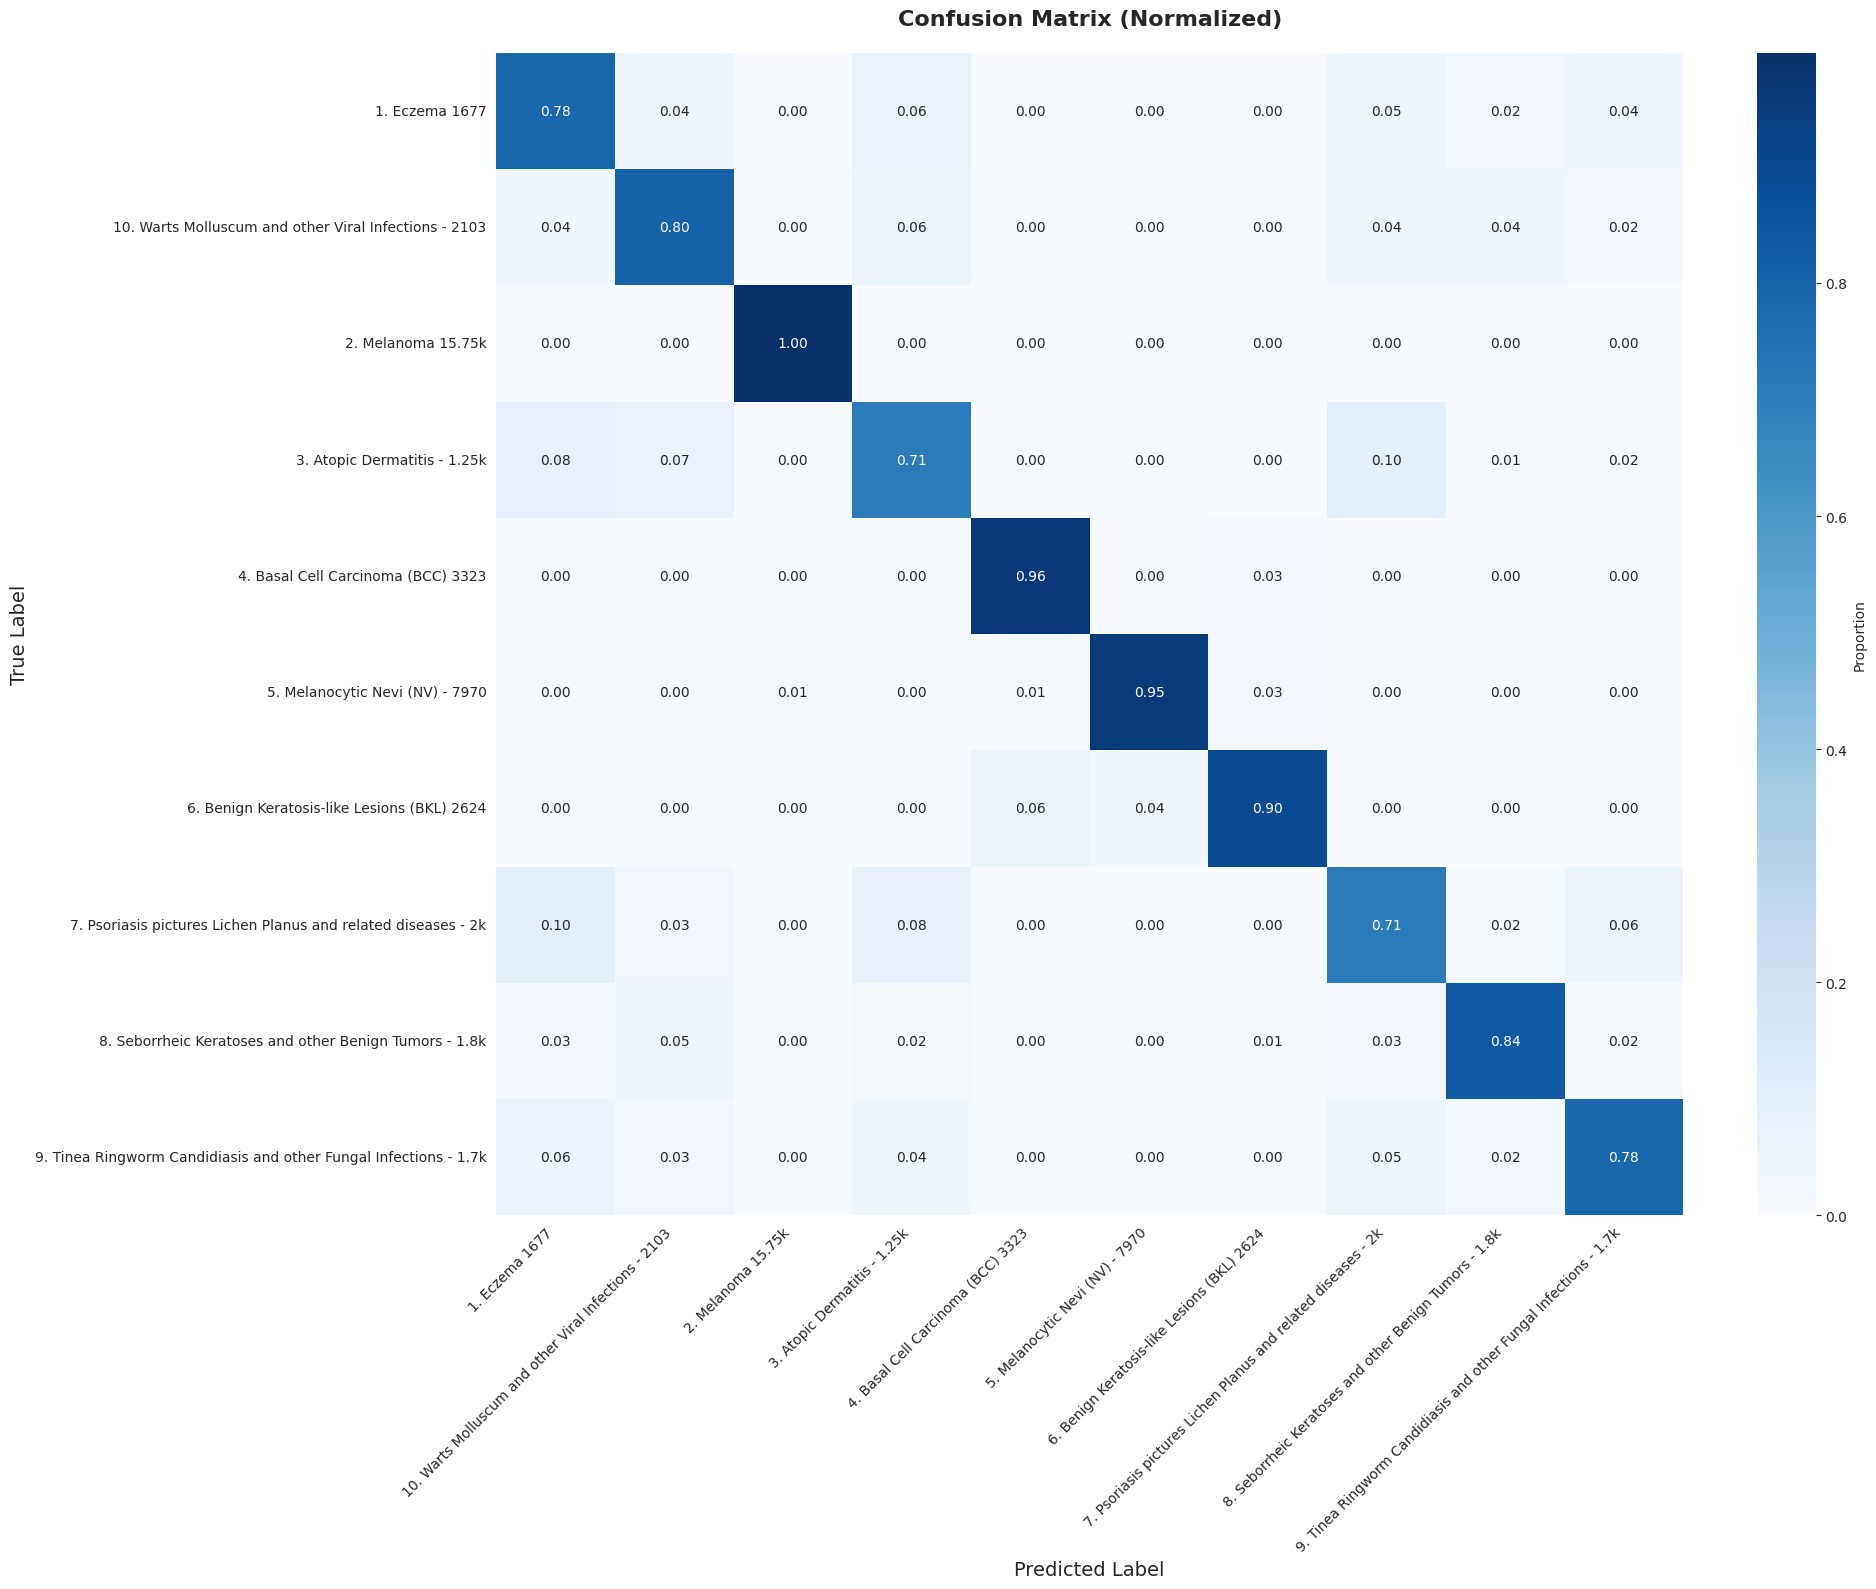

In [51]:
# Plot confusion matrix
plot_confusion_matrix(
    oof_targets,
    oof_pred_classes,
    class_names,
    save_path=f'{CFG.OUTPUT_DIR}/confusion_matrix.png'
)

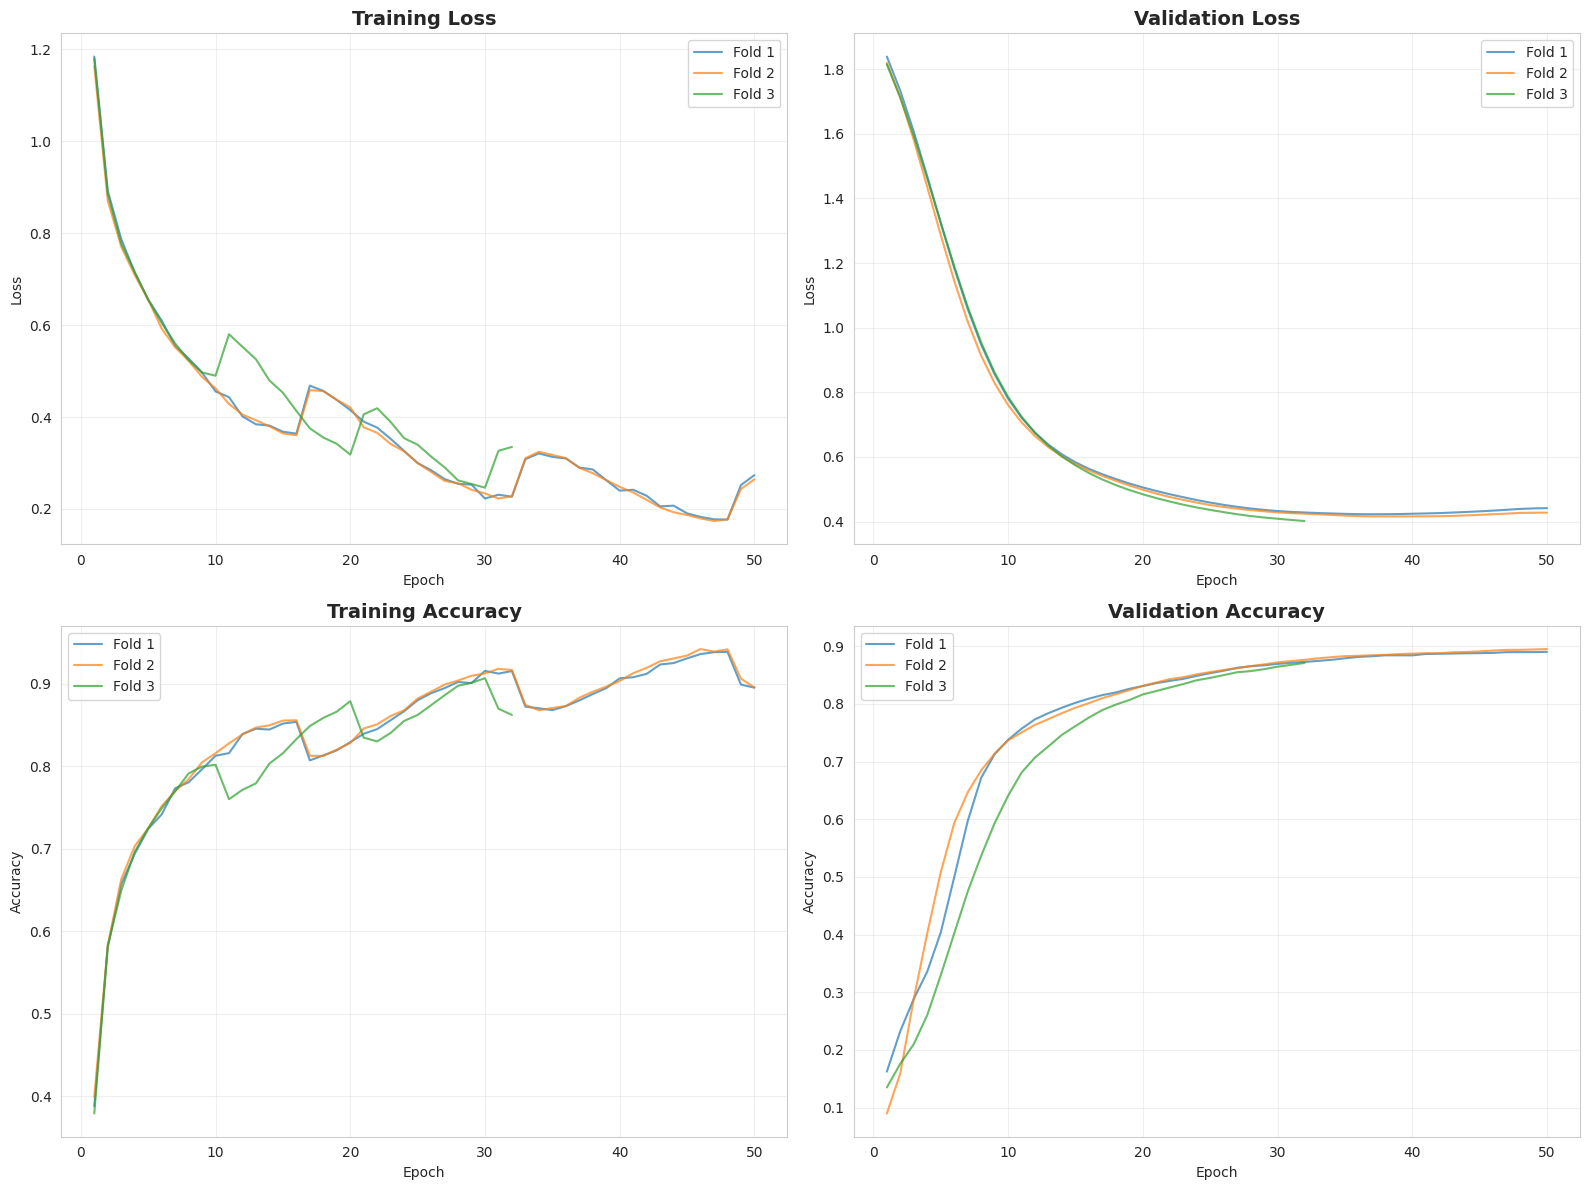

In [52]:
# Plot training history
plot_training_history(
    fold_results,
    save_path=f'{CFG.OUTPUT_DIR}/training_history.png'
)

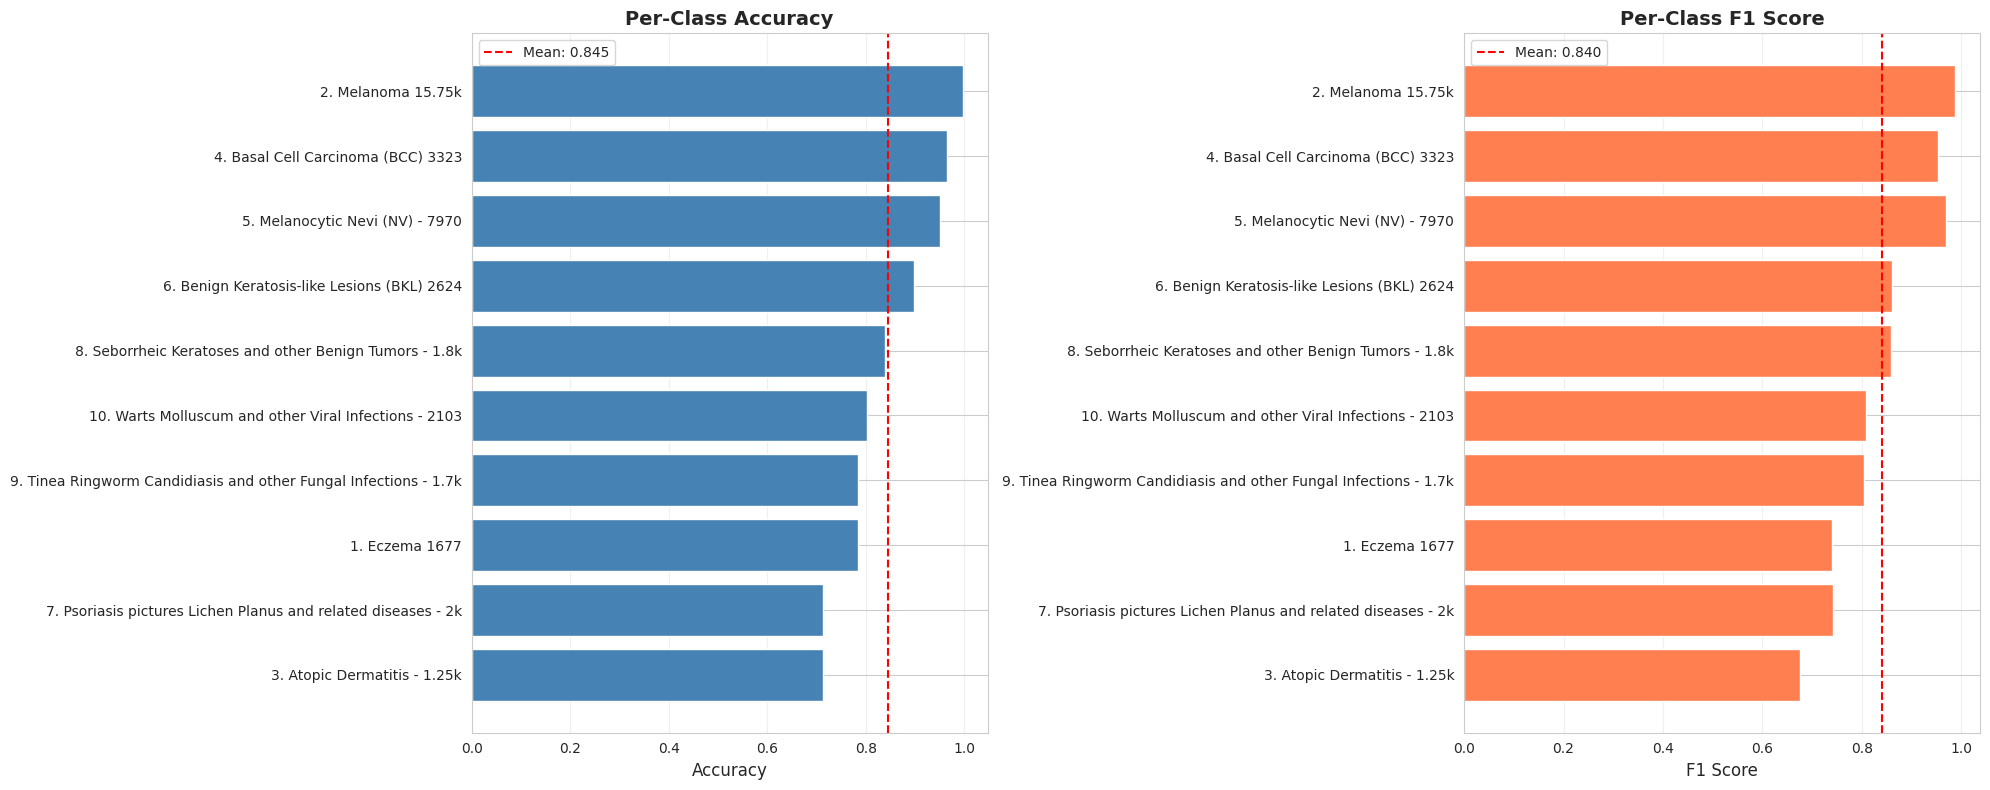


Per-Class Performance:
                                                           Class  Accuracy  F1-Score  Support
                                    3. Atopic Dermatitis - 1.25k  0.712808  0.675971     1257
   7. Psoriasis pictures Lichen Planus and related diseases - 2k  0.712895  0.741772     2055
                                                  1. Eczema 1677  0.783542  0.741117     1677
9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k  0.784371  0.804944     1702
           10. Warts Molluscum and other Viral Infections - 2103  0.803614  0.808419     2103
          8. Seborrheic Keratoses and other Benign Tumors - 1.8k  0.839740  0.859518     1847
                     6. Benign Keratosis-like Lesions (BKL) 2624  0.898509  0.861226     2079
                                 5. Melanocytic Nevi (NV) - 7970  0.951568  0.968830     7970
                              4. Basal Cell Carcinoma (BCC) 3323  0.964791  0.954025     3323
                                    

In [53]:
# Plot per-class metrics
metrics_df = plot_per_class_metrics(
    oof_targets,
    oof_pred_classes,
    class_names,
    save_path=f'{CFG.OUTPUT_DIR}/per_class_metrics.png'
)

print("\nPer-Class Performance:")
print(metrics_df.to_string(index=False))

# Identify weakest classes
print("\n⚠️  Weakest 3 Classes:")
for idx, row in metrics_df.head(3).iterrows():
    print(f"  {row['Class']}: Acc={row['Accuracy']:.3f}, F1={row['F1-Score']:.3f}, Support={int(row['Support'])}")

## 💾 17. Save Results

In [55]:
# Save OOF predictions
oof_df = df.copy()
oof_df['oof_prediction'] = oof_pred_classes
oof_df['oof_correct'] = (oof_df['label'] == oof_df['oof_prediction']).astype(int)

# Add probability columns
for i, class_name in enumerate(class_names):
    oof_df[f'prob_{class_name}'] = oof_predictions[:, i]

oof_df.to_csv(f'{CFG.OUTPUT_DIR}/oof_predictions.csv', index=False)
print(f"✓ OOF predictions saved to {CFG.OUTPUT_DIR}/oof_predictions.csv")

# Save fold results
fold_results_df = pd.DataFrame([
    {
        'fold': r['fold'],
        'best_accuracy': r['best_acc'],
        'best_epoch': r['best_epoch']
    }
    for r in fold_results
])
fold_results_df.to_csv(f'{CFG.OUTPUT_DIR}/fold_results.csv', index=False)
print(f"✓ Fold results saved to {CFG.OUTPUT_DIR}/fold_results.csv")

# Save config - with proper type handling
import torch
import numpy as np

def make_serializable(obj):
    """Convert non-serializable objects to serializable ones"""
    if isinstance(obj, torch.Tensor):
        return obj.cpu().detach().tolist()
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.int64, np.int32, np.int16, np.int8)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32, np.float16)):
        return float(obj)
    elif isinstance(obj, list):
        return [make_serializable(item) for item in obj]
    elif isinstance(obj, dict):
        return {k: make_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, (str, int, float, bool, type(None))):
        return obj
    else:
        return str(obj)  # Fallback: convert to string

config_dict = {k: make_serializable(v) for k, v in CFG.__dict__.items() if not k.startswith('_')}
config_dict['CLASS_NAMES'] = class_names
config_dict['CLASS_WEIGHTS'] = make_serializable(CFG.CLASS_WEIGHTS)
config_dict['TRAIN_FOLDS'] = CFG.TRAIN_FOLDS

with open(f'{CFG.OUTPUT_DIR}/config.json', 'w') as f:
    json.dump(config_dict, f, indent=4)
print(f"✓ Configuration saved to {CFG.OUTPUT_DIR}/config.json")

# Save numpy arrays
np.save(f'{CFG.OUTPUT_DIR}/oof_predictions.npy', oof_predictions)
np.save(f'{CFG.OUTPUT_DIR}/oof_targets.npy', oof_targets)
print(f"✓ NumPy arrays saved")

✓ OOF predictions saved to ./outputs/oof_predictions.csv
✓ Fold results saved to ./outputs/fold_results.csv
✓ Configuration saved to ./outputs/config.json
✓ NumPy arrays saved


## 🎯 18. Final Summary & Next Steps

In [57]:
# Final training summary
print("\n" + "="*70)
print("📊 FINAL TRAINING SUMMARY")
print("="*70)

print(f"\n🎯 Model Configuration:")
print(f"   Backbone: {CFG.BACKBONE}")
print(f"   Image Size: {CFG.IMG_SIZE}x{CFG.IMG_SIZE}")
print(f"   Number of Classes: {CFG.NUM_CLASSES}")
print(f"   Batch Size: {CFG.EFFECTIVE_BATCH_SIZE}")
print(f"   Epochs Trained: {CFG.EPOCHS}")

print(f"\n📈 Performance Metrics:")
print(f"   OOF Accuracy: {oof_acc:.4f} ({oof_acc*100:.2f}%)")
print(f"   OOF F1-Score: {oof_f1:.4f}")
print(f"   OOF Balanced Accuracy: {oof_balanced_acc:.4f}")
print(f"   OOF ECE: {oof_ece:.4f}")

if fold_results:
    fold_accs = [r['best_acc'] for r in fold_results]
    print(f"\n🔄 Cross-Validation:")
    print(f"   Number of Folds: {len(fold_results)}")
    print(f"   Mean Accuracy: {np.mean(fold_accs):.4f}")
    print(f"   Std Accuracy: {np.std(fold_accs):.4f}")
    print(f"   Best Fold: {np.argmax(fold_accs)} ({np.max(fold_accs):.4f})")
    print(f"   Worst Fold: {np.argmin(fold_accs)} ({np.min(fold_accs):.4f})")

print(f"\n💾 Saved Outputs:")
print(f"   Output Directory: {CFG.OUTPUT_DIR}")
print(f"   Model Checkpoints: {len([f for f in os.listdir(CFG.OUTPUT_DIR) if f.endswith('.pth')])} files")
print(f"   Visualizations: {len([f for f in os.listdir(CFG.OUTPUT_DIR) if f.endswith('.png')])} plots")
print(f"   CSV Reports: {len([f for f in os.listdir(CFG.OUTPUT_DIR) if f.endswith('.csv')])} files")

print(f"\n🎓 Achievement Level:")
if oof_acc >= 0.95:
    print(f"   ⭐⭐⭐⭐⭐ OUTSTANDING! (95%+)")
elif oof_acc >= 0.90:
    print(f"   ⭐⭐⭐⭐ EXCELLENT! (90-95%)")
elif oof_acc >= 0.85:
    print(f"   ⭐⭐⭐ VERY GOOD! (85-90%)")
elif oof_acc >= 0.80:
    print(f"   ⭐⭐ GOOD! (80-85%)")
else:
    print(f"   ⭐ BASELINE (80%-)")

print("\n" + "="*70)

# Save summary to text file
summary_file = f'{CFG.OUTPUT_DIR}/training_summary.txt'
with open(summary_file, 'w') as f:
    f.write("="*70 + "\n")
    f.write("TRAINING SUMMARY\n")
    f.write("="*70 + "\n\n")
    f.write(f"Backbone: {CFG.BACKBONE}\n")
    f.write(f"Image Size: {CFG.IMG_SIZE}x{CFG.IMG_SIZE}\n")
    f.write(f"Number of Classes: {CFG.NUM_CLASSES}\n")
    f.write(f"Epochs: {CFG.EPOCHS}\n\n")
    f.write(f"OOF Accuracy: {oof_acc:.4f} ({oof_acc*100:.2f}%)\n")
    f.write(f"OOF F1-Score: {oof_f1:.4f}\n")
    f.write(f"OOF Balanced Accuracy: {oof_balanced_acc:.4f}\n")
    f.write(f"OOF ECE: {oof_ece:.4f}\n")

print(f"\n✓ Summary saved to: {summary_file}")


📊 FINAL TRAINING SUMMARY

🎯 Model Configuration:
   Backbone: convnext_small.fb_in22k_ft_in1k
   Image Size: 256x256
   Number of Classes: 10
   Batch Size: 32
   Epochs Trained: 50

📈 Performance Metrics:
   OOF Accuracy: 0.8854 (88.54%)
   OOF F1-Score: 0.8404
   OOF Balanced Accuracy: 0.8449
   OOF ECE: 0.0674

🔄 Cross-Validation:
   Number of Folds: 3
   Mean Accuracy: 0.8854
   Std Accuracy: 0.0104
   Best Fold: 1 (0.8950)
   Worst Fold: 2 (0.8710)

💾 Saved Outputs:
   Output Directory: ./outputs
   Model Checkpoints: 3 files
   Visualizations: 4 plots
   CSV Reports: 2 files

🎓 Achievement Level:
   ⭐⭐⭐ VERY GOOD! (85-90%)


✓ Summary saved to: ./outputs/training_summary.txt


## 🔮 19. BONUS: Simple Inference Example

In [59]:
# Simple ensemble inference function
@torch.no_grad()
def predict_image(image_path, models, transform, class_names, device):
    """Predict a single image using ensemble of models."""
    
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Apply transform
    augmented = transform(image=image)
    img_tensor = augmented['image'].unsqueeze(0).to(device)
    
    # Get predictions from all models
    all_probs = []
    for model in models:
        model.eval()
        outputs = model(img_tensor)
        probs = F.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
    
    # Average predictions
    mean_probs = np.mean(all_probs, axis=0)[0]
    
    # Get top prediction
    pred_class = np.argmax(mean_probs)
    confidence = mean_probs[pred_class]
    
    return {
        'class': class_names[pred_class],
        'confidence': confidence,
        'probabilities': {class_names[i]: mean_probs[i] for i in range(len(class_names))}
    }


# Load all fold models for inference
def load_ensemble_models(output_dir, config):
    """Load all trained fold models."""
    models = []
    
    for fold in range(config.N_FOLDS):
        checkpoint_path = f'{output_dir}/fold{fold}_best.pth'
        
        if os.path.exists(checkpoint_path):
            # Create model
            model = ImageClassifier(
                backbone=config.BACKBONE,
                num_classes=config.NUM_CLASSES,
                pretrained=False,
                use_gem=config.USE_GEM_POOLING,
                gem_p=config.GEM_P_INIT
            ).to(config.DEVICE)
            
            # Load checkpoint
            checkpoint = torch.load(checkpoint_path, map_location=config.DEVICE)
            model.load_state_dict(checkpoint['model_state_dict'])
            model.eval()
            
            models.append(model)
            print(f"✓ Loaded fold {fold} model")
    
    return models

print("✓ Inference functions defined")
print("\nTo use:")
print("  1. ensemble_models = load_ensemble_models(CFG.OUTPUT_DIR, CFG)")
print("  2. result = predict_image('path/to/image.jpg', ensemble_models, get_valid_transforms(CFG.IMG_SIZE), class_names, CFG.DEVICE)")
print("  3. print(result)")

✓ Inference functions defined

To use:
  1. ensemble_models = load_ensemble_models(CFG.OUTPUT_DIR, CFG)
  2. result = predict_image('path/to/image.jpg', ensemble_models, get_valid_transforms(CFG.IMG_SIZE), class_names, CFG.DEVICE)
  3. print(result)


## 📦 20. Backup Results for Kaggle

**Important for Kaggle users:**
- Kaggle automatically saves all files in `/kaggle/working/` to the Output tab
- You can also create a zip backup for easy download|
- The zip will appear in the **Output** tab on the right side →

In [60]:
# Check if we're running on Kaggle
import os
import shutil

is_kaggle = os.path.exists('/kaggle/working')

if is_kaggle:
    print("✓ Running on Kaggle")
    print(f"✓ Output directory: {CFG.OUTPUT_DIR}")
    print(f"✓ Files are automatically saved to Output tab")
else:
    print("ℹ️  Not running on Kaggle")
    print(f"✓ Output directory: {os.path.abspath(CFG.OUTPUT_DIR)}")

✓ Running on Kaggle
✓ Output directory: ./outputs
✓ Files are automatically saved to Output tab


In [61]:
# List all output files
print("\n" + "="*70)
print("📁 OUTPUT FILES")
print("="*70 + "\n")

if os.path.exists(CFG.OUTPUT_DIR):
    files = os.listdir(CFG.OUTPUT_DIR)
    
    total_size = 0
    for f in sorted(files):
        filepath = os.path.join(CFG.OUTPUT_DIR, f)
        if os.path.isfile(filepath):
            size = os.path.getsize(filepath)
            total_size += size
            size_mb = size / (1024 * 1024)
            print(f"  {f:<40} {size_mb:>8.2f} MB")
    
    print(f"\n  {'Total:':<40} {total_size / (1024 * 1024):>8.2f} MB")
    print(f"  {'Number of files:':<40} {len(files):>8}")
else:
    print(f"  ⚠️  Output directory not found: {CFG.OUTPUT_DIR}")

print("\n" + "="*70)


📁 OUTPUT FILES

  class_distribution.png                       0.20 MB
  config.json                                  0.00 MB
  confusion_matrix.png                         0.35 MB
  fold0_best.pth                             566.51 MB
  fold1_best.pth                             566.51 MB
  fold2_best.pth                             566.51 MB
  fold_results.csv                             0.00 MB
  oof_predictions.csv                          9.97 MB
  oof_predictions.npy                          2.07 MB
  oof_targets.npy                              0.21 MB
  per_class_metrics.png                        0.12 MB
  training_history.png                         0.24 MB
  training_summary.txt                         0.00 MB

  Total:                                    1712.70 MB
  Number of files:                               13



In [62]:
# Create backup zip file
print("\n" + "="*70)
print("📦 CREATING BACKUP ZIP")
print("="*70 + "\n")

zip_filename = 'outputs_backup.zip'

# Remove old zip if exists
if os.path.exists(zip_filename):
    os.remove(zip_filename)
    print(f"Removed old {zip_filename}")

# Create zip file
print(f"Creating {zip_filename}...")
!zip -r -q outputs_backup.zip {CFG.OUTPUT_DIR}/

# Check if successful
if os.path.exists(zip_filename):
    size_mb = os.path.getsize(zip_filename) / (1024 * 1024)
    print(f"\n✅ Backup created successfully!")
    print(f"   File: {zip_filename}")
    print(f"   Size: {size_mb:.2f} MB")
    print(f"   Location: {os.path.abspath(zip_filename)}")
    
    if is_kaggle:
        print(f"\n📥 TO DOWNLOAD:")
        print(f"   1. Look at the RIGHT side of this page")
        print(f"   2. Click the 'Output' tab")
        print(f"   3. Find '{zip_filename}'")
        print(f"   4. Click to download")
        print(f"\n💡 TIP: You can also download individual files from the Output tab")
    else:
        print(f"\n📥 Zip file ready at: {os.path.abspath(zip_filename)}")
else:
    print("\n❌ Failed to create zip file!")
    print("   Make sure the output directory exists and has files")

print("\n" + "="*70)


📦 CREATING BACKUP ZIP

Creating outputs_backup.zip...

✅ Backup created successfully!
   File: outputs_backup.zip
   Size: 1583.34 MB
   Location: /kaggle/working/outputs_backup.zip

📥 TO DOWNLOAD:
   1. Look at the RIGHT side of this page
   2. Click the 'Output' tab
   3. Find 'outputs_backup.zip'
   4. Click to download

💡 TIP: You can also download individual files from the Output tab



In [63]:
# Optional: Display download link (works in some Jupyter environments)
try:
    from IPython.display import FileLink, display
    
    if os.path.exists(zip_filename):
        print("\n📎 Download Link (click if available):")
        display(FileLink(zip_filename))
        print("\nℹ️  Note: Link may not work in all environments")
        print("   In Kaggle, use the Output tab instead")
except Exception as e:
    print(f"\nℹ️  Download link not available in this environment")
    print(f"   Use the Output tab to download files")


📎 Download Link (click if available):


/kaggle/working/outputs_backup.zip


ℹ️  Note: Link may not work in all environments
   In Kaggle, use the Output tab instead


## 📊 21. Training Summary & Final Stats

In [64]:
# Final training summary
print("\n" + "="*70)
print("📊 FINAL TRAINING SUMMARY")
print("="*70)

print(f"\n🎯 Model Configuration:")
print(f"   Backbone: {CFG.BACKBONE}")
print(f"   Image Size: {CFG.IMG_SIZE}x{CFG.IMG_SIZE}")
print(f"   Number of Classes: {CFG.NUM_CLASSES}")
print(f"   Batch Size: {CFG.EFFECTIVE_BATCH_SIZE}")
print(f"   Epochs Trained: {CFG.EPOCHS}")

print(f"\n📈 Performance Metrics:")
print(f"   OOF Accuracy: {oof_acc:.4f} ({oof_acc*100:.2f}%)")
print(f"   OOF F1-Score: {oof_f1:.4f}")
print(f"   OOF Balanced Accuracy: {oof_balanced_acc:.4f}")
print(f"   OOF ECE: {oof_ece:.4f}")

if fold_results:
    fold_accs = [r['best_acc'] for r in fold_results]
    print(f"\n🔄 Cross-Validation:")
    print(f"   Number of Folds: {len(fold_results)}")
    print(f"   Mean Accuracy: {np.mean(fold_accs):.4f}")
    print(f"   Std Accuracy: {np.std(fold_accs):.4f}")
    print(f"   Best Fold: {np.argmax(fold_accs)} ({np.max(fold_accs):.4f})")
    print(f"   Worst Fold: {np.argmin(fold_accs)} ({np.min(fold_accs):.4f})")

print(f"\n💾 Saved Outputs:")
print(f"   Output Directory: {CFG.OUTPUT_DIR}")
print(f"   Model Checkpoints: {len([f for f in os.listdir(CFG.OUTPUT_DIR) if f.endswith('.pth')])} files")
print(f"   Visualizations: {len([f for f in os.listdir(CFG.OUTPUT_DIR) if f.endswith('.png')])} plots")
print(f"   CSV Reports: {len([f for f in os.listdir(CFG.OUTPUT_DIR) if f.endswith('.csv')])} files")

print(f"\n🎓 Achievement Level:")
if oof_acc >= 0.95:
    print(f"   ⭐⭐⭐⭐⭐ OUTSTANDING! (95%+)")
elif oof_acc >= 0.90:
    print(f"   ⭐⭐⭐⭐ EXCELLENT! (90-95%)")
elif oof_acc >= 0.85:
    print(f"   ⭐⭐⭐ VERY GOOD! (85-90%)")
elif oof_acc >= 0.80:
    print(f"   ⭐⭐ GOOD! (80-85%)")
else:
    print(f"   ⭐ BASELINE (80%-)")

print("\n" + "="*70)

# Save summary to text file
summary_file = f'{CFG.OUTPUT_DIR}/training_summary.txt'
with open(summary_file, 'w') as f:
    f.write("="*70 + "\n")
    f.write("TRAINING SUMMARY\n")
    f.write("="*70 + "\n\n")
    f.write(f"Backbone: {CFG.BACKBONE}\n")
    f.write(f"Image Size: {CFG.IMG_SIZE}x{CFG.IMG_SIZE}\n")
    f.write(f"Number of Classes: {CFG.NUM_CLASSES}\n")
    f.write(f"Epochs: {CFG.EPOCHS}\n\n")
    f.write(f"OOF Accuracy: {oof_acc:.4f} ({oof_acc*100:.2f}%)\n")
    f.write(f"OOF F1-Score: {oof_f1:.4f}\n")
    f.write(f"OOF Balanced Accuracy: {oof_balanced_acc:.4f}\n")
    f.write(f"OOF ECE: {oof_ece:.4f}\n")

print(f"\n✓ Summary saved to: {summary_file}")


📊 FINAL TRAINING SUMMARY

🎯 Model Configuration:
   Backbone: convnext_small.fb_in22k_ft_in1k
   Image Size: 256x256
   Number of Classes: 10
   Batch Size: 32
   Epochs Trained: 50

📈 Performance Metrics:
   OOF Accuracy: 0.8854 (88.54%)
   OOF F1-Score: 0.8404
   OOF Balanced Accuracy: 0.8449
   OOF ECE: 0.0674

🔄 Cross-Validation:
   Number of Folds: 3
   Mean Accuracy: 0.8854
   Std Accuracy: 0.0104
   Best Fold: 1 (0.8950)
   Worst Fold: 2 (0.8710)

💾 Saved Outputs:
   Output Directory: ./outputs
   Model Checkpoints: 3 files
   Visualizations: 4 plots
   CSV Reports: 2 files

🎓 Achievement Level:
   ⭐⭐⭐ VERY GOOD! (85-90%)


✓ Summary saved to: ./outputs/training_summary.txt


## 🎊 Congratulations!

You've completed the production-grade CNN training pipeline!

### 📚 What You Built:
- ✅ Complete end-to-end training pipeline
- ✅ 5-fold cross-validation with stratification
- ✅ Advanced data augmentation
- ✅ State-of-the-art model architecture
- ✅ EMA for better convergence
- ✅ Mixed precision training
- ✅ Comprehensive evaluation metrics
- ✅ Beautiful visualizations
- ✅ Ready-to-use inference code

### 🚀 Next Steps:
1. Analyze your confusion matrix to identify problem classes
2. Try different hyperparameters (learning rate, image size, etc.)
3. Experiment with different backbones
4. Use the ensemble for production inference
5. Apply Test-Time Augmentation for extra boost

**Happy Training! 🎉**